In [ ]:
# Algorithm
1. Merge all data files (census, business type, and Flickr) using zip codes as primary key. 
2. Run linear regression (at the end of the notebook)
3. Transform the problem as classification
4. Try multiple classifiers
5. Run

In [280]:
import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import seaborn as sns
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)
from census import Census
from us import states
import csv

# Cleaning and merging data

In [2]:
#biz type
"""
    11	Agriculture, Forestry, Fishing and Hunting
    21	Mining, Quarrying, and Oil and Gas Extraction
    22	Utilities
    #23	Construction
    31-33	Manufacturing
    #42	Wholesale Trade
    #44-45	Retail Trade
    48-49	Transportation and Warehousing
    #51	Information
    #52	Finance and Insurance
    #53	Real Estate and Rental and Leasing
    #54	Professional, Scientific, and Technical Services
    #55	Management of Companies and Enterprises
    56	Administrative and Support and Waste Management and Remediation Services
    61	Educational Services
    62	Health Care and Social Assistance
    71	Arts, Entertainment, and Recreation
    #72	Accommodation and Food Services
    81	Other Services (except Public Administration)
    92	Public Administration
    
    potential parameters: 23, 42, 45, 51, 52, 53, 54, 55, 72
"""
business_codes = [11, 21, 22, 23, 30, 42, 45, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 99]
business_names = ['Agriculture/Fishing','Mining/Gas Extraction','Utilities','Construction',
                  'Manufacturing','Wholesale','Retail','Transportation','Media/Publishing',
                  'Finance','Real Estate','Law/Science/Ads','Management','Administrative',
                  'Education','Health','Arts','Accommodation/Food','Others','Public']

In [3]:
# zip code: this is from biz file
np.load('new_zip_codes.npy')
# flickr data -> no nan, no inf
df_art = pd.read_csv('art_rate.csv')
# census
df_cen = pd.read_csv('census_filtered.csv')
# predictor
df_biz = pd.read_csv('biz_growth.csv')

In [4]:
# zip code with city names
df_city = pd.read_csv('city_zip_df.csv')
df_city.head()

city state  zipcodes
0  Baltimore    MD     21201
1  Baltimore    MD     21202
2  Baltimore    MD     21205
3  Baltimore    MD     21206
4  Baltimore    MD     21207

In [5]:
df_cen.head()

TotalPop   M_Total  M_18to19      M_20      M_21  M_22to24  M_25to29  \
0 -0.018745  0.025664  0.076923  0.256410 -0.500000  0.083160  0.031599   
1  0.018566 -0.004596  0.038023  0.244361 -0.004454 -0.021987 -0.053431   
2  0.029790  0.033835  0.067524 -0.071942  0.151316 -0.088384  0.141667   
3 -0.020165 -0.011558  0.159664  0.231481  0.033708 -0.012547 -0.165234   
4 -0.010570 -0.020922  0.301708 -0.290844 -0.015152 -0.084223 -0.050765   

   M_30to34   F_Total  F_18to19    ...     F_Total_Edu      F_BA      F_MA  \
0  0.219780 -0.051964  0.132812    ...       -0.076227 -0.077049 -0.040000   
1  0.008483  0.050930 -0.060976    ...        0.058900  0.040836  0.076677   
2  0.204819  0.026208  0.066845    ...       -0.008950  0.200000  0.265734   
3  0.019583 -0.027440 -0.103717    ...        0.010800 -0.129573 -0.086957   
4 -0.042348 -0.002171 -0.040140    ...        0.019922  0.028470 -0.016706   

     F_Prof     F_Doc  Total_poor    M_Arts    F_Arts  year  zip_code  
0 -0.132743 -0.020979   -0.000169  0.291925 -0.109804  2011     21201  
1  0.130435  0.112676    0.037575 -0.157895 -0.104478  2011     21202  
2 -0.340000       NaN    0.172172       inf -0.125000  2011     21205  
3  0.383562 -0.136364    0.052441 -0.247525 -0.176000  2011     21206  
4  0.012658  0.854167    0.035589  0.026549  0.169014  2011     21207  

[5 rows x 31 columns]

In [6]:
temp = []
for zip_code in df_cen['zip_code'].values:
    temp.append(df_city.city[zip_code == df_city.zipcodes.values].values[0])

In [9]:
df_cen['city']=temp

In [10]:
# rename to prevent confusion
df_art = df_art.rename(columns={'growth':'art_growth'})
df_biz = df_biz.rename(columns={'growth':'biz_growth'})

In [11]:
df_biz.head()

business_code  biz_growth  year  zip_code
0             11    0.000000  2011     21201
1             21    0.000000  2011     21201
2             22    0.000000  2011     21201
3             23    0.052632  2011     21201
4             30   -0.300000  2011     21201

In [12]:
print df_art.columns
print df_cen.columns
print df_biz.columns

Index([u'art_growth', u'year', u'zip_code'], dtype='object')
Index([u'TotalPop', u'M_Total', u'M_18to19', u'M_20', u'M_21', u'M_22to24',
       u'M_25to29', u'M_30to34', u'F_Total', u'F_18to19', u'F_20', u'F_21',
       u'F_22to24', u'F_25to29', u'F_30to34', u'Total_Edu', u'M_Total_Edu',
       u'M_BA', u'M_MA', u'M_Prof', u'M_Doc', u'F_Total_Edu', u'F_BA', u'F_MA',
       u'F_Prof', u'F_Doc', u'Total_poor', u'M_Arts', u'F_Arts', u'year',
       u'zip_code', u'city'],
      dtype='object')
Index([u'business_code', u'biz_growth', u'year', u'zip_code'], dtype='object')


In [13]:
# putting things together: inner join
df_feat = pd.merge(df_art, df_cen, how='inner', on=['year', 'zip_code'])
df_feat.head()

art_growth  year  zip_code  TotalPop   M_Total  M_18to19      M_20  \
0    0.068309  2011     21201 -0.018745  0.025664  0.076923  0.256410   
1   -0.021482  2011     21202  0.018566 -0.004596  0.038023  0.244361   
2    0.000000  2011     21205  0.029790  0.033835  0.067524 -0.071942   
3    0.000000  2011     21206 -0.020165 -0.011558  0.159664  0.231481   
4    0.000000  2011     21207 -0.010570 -0.020922  0.301708 -0.290844   

       M_21  M_22to24  M_25to29    ...         M_Doc  F_Total_Edu      F_BA  \
0 -0.500000  0.083160  0.031599    ...      0.304167    -0.076227 -0.077049   
1 -0.004454 -0.021987 -0.053431    ...     -0.156398     0.058900  0.040836   
2  0.151316 -0.088384  0.141667    ...      1.000000    -0.008950  0.200000   
3  0.033708 -0.012547 -0.165234    ...     -0.569767     0.010800 -0.129573   
4 -0.015152 -0.084223 -0.050765    ...      0.354430     0.019922  0.028470   

       F_MA    F_Prof     F_Doc  Total_poor    M_Arts    F_Arts       city  
0 -0.040000 -0.132743 -0.020979   -0.000169  0.291925 -0.109804  Baltimore  
1  0.076677  0.130435  0.112676    0.037575 -0.157895 -0.104478  Baltimore  
2  0.265734 -0.340000       NaN    0.172172       inf -0.125000  Baltimore  
3 -0.086957  0.383562 -0.136364    0.052441 -0.247525 -0.176000  Baltimore  
4 -0.016706  0.012658  0.854167    0.035589  0.026549  0.169014  Baltimore  

[5 rows x 33 columns]

In [14]:
df_corr = df_feat

In [15]:
# converting nan -> 0
# converting inf -> 2
columns = df_feat.columns
for column in columns[:-1]:
    for i in range(len(df_feat)):
        if np.isinf((df_feat[column][i])):
            df_corr[column].values[i]=2        
        if np.isnan(df_feat[column][i]):
            df_corr[column].values[i]=0

In [16]:
df_corr.head()

art_growth  year  zip_code  TotalPop   M_Total  M_18to19      M_20  \
0    0.068309  2011     21201 -0.018745  0.025664  0.076923  0.256410   
1   -0.021482  2011     21202  0.018566 -0.004596  0.038023  0.244361   
2    0.000000  2011     21205  0.029790  0.033835  0.067524 -0.071942   
3    0.000000  2011     21206 -0.020165 -0.011558  0.159664  0.231481   
4    0.000000  2011     21207 -0.010570 -0.020922  0.301708 -0.290844   

       M_21  M_22to24  M_25to29    ...         M_Doc  F_Total_Edu      F_BA  \
0 -0.500000  0.083160  0.031599    ...      0.304167    -0.076227 -0.077049   
1 -0.004454 -0.021987 -0.053431    ...     -0.156398     0.058900  0.040836   
2  0.151316 -0.088384  0.141667    ...      1.000000    -0.008950  0.200000   
3  0.033708 -0.012547 -0.165234    ...     -0.569767     0.010800 -0.129573   
4 -0.015152 -0.084223 -0.050765    ...      0.354430     0.019922  0.028470   

       F_MA    F_Prof     F_Doc  Total_poor    M_Arts    F_Arts       city  
0 -0.040000 -0.132743 -0.020979   -0.000169  0.291925 -0.109804  Baltimore  
1  0.076677  0.130435  0.112676    0.037575 -0.157895 -0.104478  Baltimore  
2  0.265734 -0.340000  0.000000    0.172172  2.000000 -0.125000  Baltimore  
3 -0.086957  0.383562 -0.136364    0.052441 -0.247525 -0.176000  Baltimore  
4 -0.016706  0.012658  0.854167    0.035589  0.026549  0.169014  Baltimore  

[5 rows x 33 columns]

In [17]:
# check biz column value: if inf -> 2
for i in range(len(df_biz)):
    biz_growth_num = df_biz['biz_growth'][i]
    if np.isinf(biz_growth_num):
        df_biz['biz_growth'][i]=2

In [18]:
# merge with biz
df_all = pd.merge(df_corr, df_biz, how='inner', on=['year', 'zip_code'])

In [32]:
df_all.head()

year  zip_code  TotalPop   M_Total  M_18to19     M_20  M_21  M_22to24  \
0  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
1  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
2  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
3  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
4  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   

   M_25to29  M_30to34    ...        F_Prof     F_Doc  Total_poor    M_Arts  \
0  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
1  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
2  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
3  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
4  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   

     F_Arts  art_growth  business_code  biz_growth       city  biz_index  
0 -0.109804    0.068309             11    0.000000  Baltimore          0  
1 -0.109804    0.068309             21    0.000000  Baltimore          0  
2 -0.109804    0.068309             22    0.000000  Baltimore          0  
3 -0.109804    0.068309             23    0.052632  Baltimore          2  
4 -0.109804    0.068309             30   -0.300000  Baltimore          0  

[5 rows x 36 columns]

In [20]:
# change the column order for the future
temp = df_all.ix[:,1:32]
temp['art_growth']=df_all['art_growth']
temp['business_code']=df_all['business_code']
temp['biz_growth']=df_all['biz_growth']
temp['city']=df_all['city']
df_all = temp

In [21]:
df_all.head()

year  zip_code  TotalPop   M_Total  M_18to19     M_20  M_21  M_22to24  \
0  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
1  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
2  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
3  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
4  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   

   M_25to29  M_30to34    ...      F_MA    F_Prof     F_Doc  Total_poor  \
0  0.031599   0.21978    ...     -0.04 -0.132743 -0.020979   -0.000169   
1  0.031599   0.21978    ...     -0.04 -0.132743 -0.020979   -0.000169   
2  0.031599   0.21978    ...     -0.04 -0.132743 -0.020979   -0.000169   
3  0.031599   0.21978    ...     -0.04 -0.132743 -0.020979   -0.000169   
4  0.031599   0.21978    ...     -0.04 -0.132743 -0.020979   -0.000169   

     M_Arts    F_Arts  art_growth  business_code  biz_growth       city  
0  0.291925 -0.109804    0.068309             11    0.000000  Baltimore  
1  0.291925 -0.109804    0.068309             21    0.000000  Baltimore  
2  0.291925 -0.109804    0.068309             22    0.000000  Baltimore  
3  0.291925 -0.109804    0.068309             23    0.052632  Baltimore  
4  0.291925 -0.109804    0.068309             30   -0.300000  Baltimore  

[5 rows x 35 columns]

In [56]:
# save
df_all.to_csv('data_city.csv',encoding='utf-8',index=False)

# 0. Assign classes

In [5]:
df_all = pd.read_csv('data_city.csv')

In [6]:
# assign indices
df_all['biz_growth'].describe()

count    20640.000000
mean         0.021505
std          0.316719
min         -1.000000
25%         -0.026316
50%          0.000000
75%          0.060000
max         10.000000
Name: biz_growth, dtype: float64

(array([  3.23000000e+02,   2.00000000e+01,   2.90000000e+01,
          9.10000000e+01,   2.41000000e+02,   1.03000000e+02,
          5.37000000e+02,   9.98000000e+02,   3.47800000e+03,
          1.12430000e+04,   1.88100000e+03,   6.05000000e+02,
          3.64000000e+02,   2.06000000e+02,   5.00000000e+01,
          9.60000000e+01,   1.60000000e+01,   4.00000000e+00,
          2.10000000e+02,   1.10000000e+01,   5.00000000e+00,
          9.00000000e+00,   1.90000000e+01,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          5.40000000e+01,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.50000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          9.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

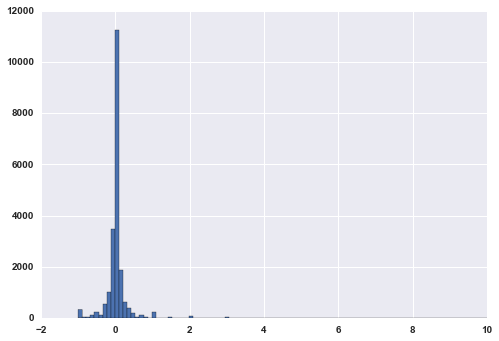

In [7]:
plt.hist(df_all['biz_growth'],100)

In [8]:
# create index: 3
def assign_biz_multiclass1(num):
    temp = []
    for biz_growth in df_all['biz_growth'].values:
        if biz_growth <= 0.0:
            biz_index = 0
        elif biz_growth > 0.0 and biz_growth <= num:
            biz_index = 1
        elif biz_growth > num:
            biz_index = 2
        temp.append(biz_index)
    plt.hist(temp)
    return temp

In [9]:
# create index: 4
def assign_biz_multiclass2(num):
    temp = []
    for biz_growth in df_all['biz_growth'].values:
        if biz_growth <= 0.0:
            biz_index = 0
        elif biz_growth > 0.0 and biz_growth <= num:
            biz_index = 1
        elif biz_growth > num and biz_growth <= num*2:
            biz_index = 2
        elif biz_growth > num*2:
            biz_index = 3
        temp.append(biz_index)
    plt.hist(temp)
    return temp

In [10]:
def assign_biz_binary():
    temp = []
    for biz_growth in df_all['biz_growth'].values:
        if biz_growth <= 0.0:
            biz_index = 0
        elif biz_growth > 0.0:
            biz_index = 1
        temp.append(biz_index)
    plt.hist(temp)
    return temp

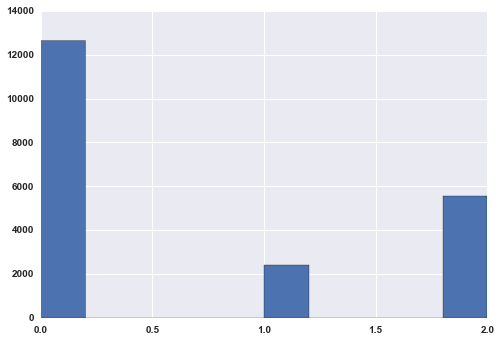

In [11]:
temp = assign_biz_multiclass1(0.05)
df_all['biz_index']=pd.DataFrame(temp)

## Do certain businesses go together?

In [12]:
gb = df_all.groupby(('year','business_code'))

In [13]:
# compute average biz_growth per business type in a year, across zip_codes
ref_years = [2011, 2012]
biz_avr_by_zip = []
for ref_year in ref_years:
    for biz_code in business_codes:
        a = gb.get_group((ref_year,biz_code))
        biz_avr_by_zip.append(np.average(a['biz_growth'].values))        

In [14]:
df_av = pd.DataFrame({'2011':biz_avr_by_zip[0:len(business_codes)],'2012':biz_avr_by_zip[len(business_codes):]})
df_av.index = business_names
df_av

2011      2012
Agriculture/Fishing   -0.012647 -0.018897
Mining/Gas Extraction -0.014696 -0.021318
Utilities             -0.002071 -0.002971
Construction           0.023427  0.029157
Manufacturing         -0.008928  0.001245
Wholesale              0.013011  0.027247
Retail                 0.022027  0.003472
Transportation         0.053618  0.029967
Media/Publishing       0.038387  0.044592
Finance                0.032544  0.003561
Real Estate            0.033791  0.015557
Law/Science/Ads        0.041238  0.027794
Management             0.035442  0.002267
Administrative         0.032993  0.026459
Education              0.073749  0.071657
Health                 0.027851  0.011775
Arts                   0.071444  0.047217
Accommodation/Food     0.043032  0.024339
Others                 0.026080  0.015499
Public                -0.376829  0.368108

In [15]:
df_av['biz_name'] = business_names

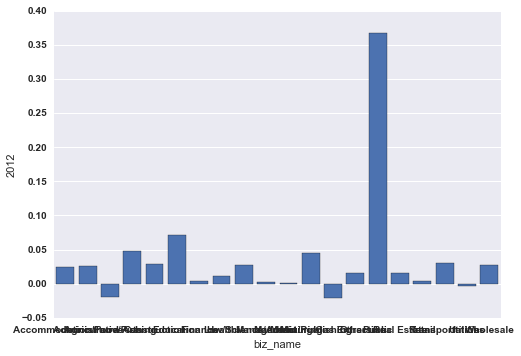

In [16]:
sns.barplot(x='biz_name',y='2012',data=df_av)

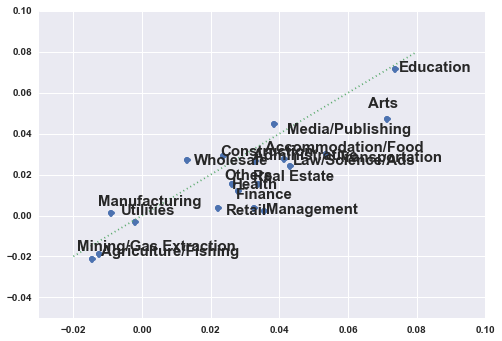

In [18]:
x = df_av['2011'][:-1]
y = df_av['2012'][:-1]
plt.plot(df_av['2011'][:-1],df_av['2012'][:-1],'o',hold='on')
plt.plot(np.linspace(-.02,.08,100),np.linspace(-.02,.08,100),':')
# plt.axis('equal')
plt.axis([-0.03, 0.10, -0.05, 0.10])

sns.set_context("poster")
mu = 0.0025
sigma = 0.003
errors = sigma * np.random.randn(len(business_names)-1) + mu

for i in range(0,len(business_codes)-1):
    biz_name = business_names[i]
    plt.annotate(biz_name, (x[i]-errors[i],y[i]+errors[i]),fontsize=15)
plt.show()    

# 1. Logistic Regression: multi-class

55.0


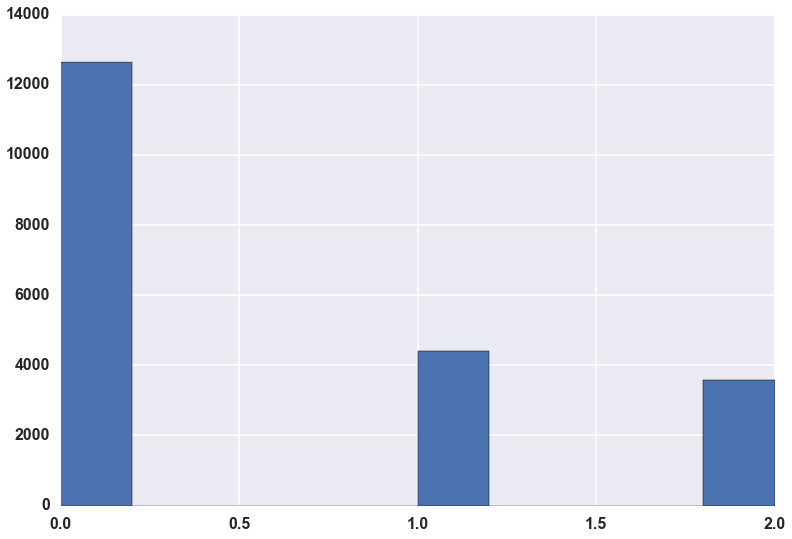

In [19]:
from sklearn import linear_model, cross_validation
from sklearn.metrics import accuracy_score

temp = assign_biz_multiclass1(0.10)
df_all['biz_index']=pd.DataFrame(temp)
gb = df_all.groupby(('year','business_code'))
scores = []
for biz_code,biz_name in zip(business_codes,business_names):

    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4
    X_train_df, X_test_df, y_train_df, y_test_df = cross_validation.train_test_split(df_2011, df_2012, test_size=test_size, random_state=0)    
    
    X_train = X_train_df.ix[:,2:32]
    X_test = X_test_df.ix[:,2:32]
    y_train = y_train_df.ix[:,-1]
    y_test = y_test_df.ix[:,-1]
    
    logreg = linear_model.LogisticRegression(multi_class='ovr',penalty='l1')#solver='lbfgs')
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
#     print biz_name + ':' + str(score)
#     rf_eval_feat(df_2011.columns[2:32],logreg,biz_name,score)
    scores.append(score)
print sum(np.array(scores)>0.5)/float(len(business_codes))*100

# 2. Test all classifires
### 2. Classification criteria

In [20]:
# Selecting classes: choose based on +/-SD
df_all[df_all.year.values==2012].biz_growth.describe()

count    10320.000000
mean         0.035336
std          0.337001
min         -1.000000
25%         -0.016667
50%          0.000000
75%          0.054945
max         10.000000
Name: biz_growth, dtype: float64

In [22]:
# plot feature importances (as a confirmation)
def rf_eval_feat(feature_names,clf,title,score):
    fig = plt.figure(figsize=(15,10))
    # sort importances
    indices = np.argsort(clf.feature_importances_)
    # plot as bar chart
    plt.barh(np.arange(len(feature_names)), clf.feature_importances_[indices])
    plt.yticks(np.arange(len(feature_names)) + 0.5, np.array(feature_names)[indices])
    _ = plt.xlabel('Relative importance')
    plt.title([title + ':' + str(score)],fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    return indices

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "LDA", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(),
    GaussianNB(),
    LDA(),
    QDA()]

## 2.1 Binomial

In [24]:
df_all.head()

year  zip_code  TotalPop   M_Total  M_18to19     M_20  M_21  M_22to24  \
0  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
1  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
2  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
3  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
4  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   

   M_25to29  M_30to34    ...        F_Prof     F_Doc  Total_poor    M_Arts  \
0  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
1  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
2  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
3  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
4  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   

     F_Arts  art_growth  business_code  biz_growth       city  biz_index  
0 -0.109804    0.068309             11    0.000000  Baltimore          0  
1 -0.109804    0.068309             21    0.000000  Baltimore          0  
2 -0.109804    0.068309             22    0.000000  Baltimore          0  
3 -0.109804    0.068309             23    0.052632  Baltimore          1  
4 -0.109804    0.068309             30   -0.300000  Baltimore          0  

[5 rows x 36 columns]

Nearest Neighbors:Agriculture/Fishing:0.971014492754
Nearest Neighbors:Mining/Gas Extraction:0.990338164251
Nearest Neighbors:Utilities:0.951690821256
Nearest Neighbors:Construction:0.521739130435
Nearest Neighbors:Manufacturing:0.632850241546
Nearest Neighbors:Wholesale:0.507246376812
Nearest Neighbors:Retail:0.531400966184
Nearest Neighbors:Transportation:0.565217391304
Nearest Neighbors:Media/Publishing:0.574879227053
Nearest Neighbors:Finance:0.473429951691
Nearest Neighbors:Real Estate:0.51690821256
Nearest Neighbors:Law/Science/Ads:0.613526570048
Nearest Neighbors:Management:0.792270531401
Nearest Neighbors:Administrative:0.545893719807
Nearest Neighbors:Education:0.468599033816
Nearest Neighbors:Health:0.502415458937
Nearest Neighbors:Arts:0.579710144928
Nearest Neighbors:Accommodation/Food:0.565217391304
Nearest Neighbors:Others:0.589371980676
Nearest Neighbors:Public:0.623188405797
90.0
Linear SVM:Agriculture/Fishing:0.971014492754
Linear SVM:Mining/Gas Extraction:0.9903381642

/Users/Hongsup/anaconda/lib/python2.7/site-packages/sklearn/qda.py:133: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


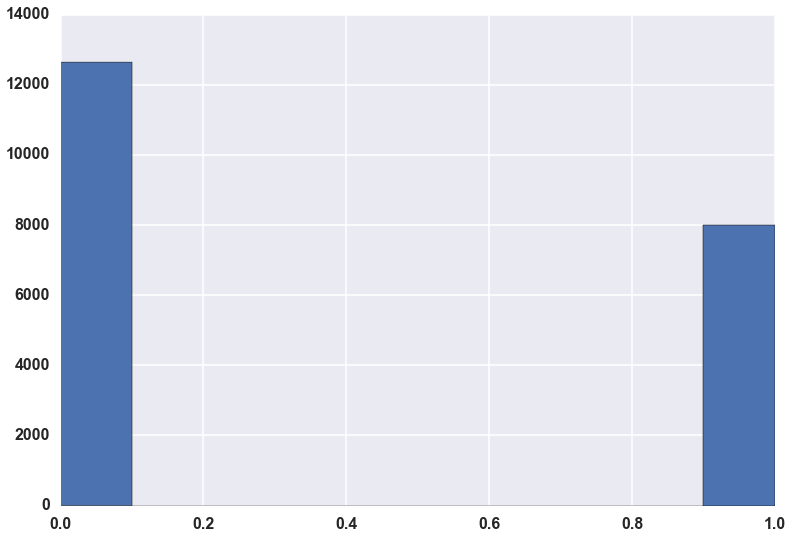

In [25]:
temp = assign_biz_binary()
df_binom = df_all
df_binom['biz_index']=pd.DataFrame(temp)
gb = df_binom.groupby(('year','business_code'))
for name, clf in zip(names, classifiers):
    scores = []
    for biz_code,biz_name in zip(business_codes,business_names):
        df_2011 = gb.get_group((2011,biz_code))
        df_2012 = gb.get_group((2012,biz_code))
        test_size = 0.4
        
        X = df_2011.ix[:,2:32]
        y = df_2012.ix[:,-1]
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
        print name+ ':' + biz_name + ':' +str(score)
    print sum(np.array(scores)>0.5)/float(len(business_codes))*100

## 2.2 Multinomial

In [26]:
df_all.head()

year  zip_code  TotalPop   M_Total  M_18to19     M_20  M_21  M_22to24  \
0  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
1  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
2  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
3  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
4  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   

   M_25to29  M_30to34    ...        F_Prof     F_Doc  Total_poor    M_Arts  \
0  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
1  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
2  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
3  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
4  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   

     F_Arts  art_growth  business_code  biz_growth       city  biz_index  
0 -0.109804    0.068309             11    0.000000  Baltimore          0  
1 -0.109804    0.068309             21    0.000000  Baltimore          0  
2 -0.109804    0.068309             22    0.000000  Baltimore          0  
3 -0.109804    0.068309             23    0.052632  Baltimore          1  
4 -0.109804    0.068309             30   -0.300000  Baltimore          0  

[5 rows x 36 columns]

Nearest Neighbors:Agriculture/Fishing:0.971014492754
Nearest Neighbors:Mining/Gas Extraction:0.990338164251
Nearest Neighbors:Utilities:0.951690821256
Nearest Neighbors:Construction:0.51690821256
Nearest Neighbors:Manufacturing:0.676328502415
Nearest Neighbors:Wholesale:0.492753623188
Nearest Neighbors:Retail:0.531400966184
Nearest Neighbors:Transportation:0.531400966184
Nearest Neighbors:Media/Publishing:0.521739130435
Nearest Neighbors:Finance:0.487922705314
Nearest Neighbors:Real Estate:0.497584541063
Nearest Neighbors:Law/Science/Ads:0.599033816425
Nearest Neighbors:Management:0.806763285024
Nearest Neighbors:Administrative:0.51690821256
Nearest Neighbors:Education:0.381642512077
Nearest Neighbors:Health:0.502415458937
Nearest Neighbors:Arts:0.51690821256
Nearest Neighbors:Accommodation/Food:0.565217391304
Nearest Neighbors:Others:0.584541062802
Nearest Neighbors:Public:0.618357487923
100.0
Linear SVM:Agriculture/Fishing:0.971014492754
Linear SVM:Mining/Gas Extraction:0.99033816425

ValueError: y has only 1 sample in class 1, covariance is ill defined.

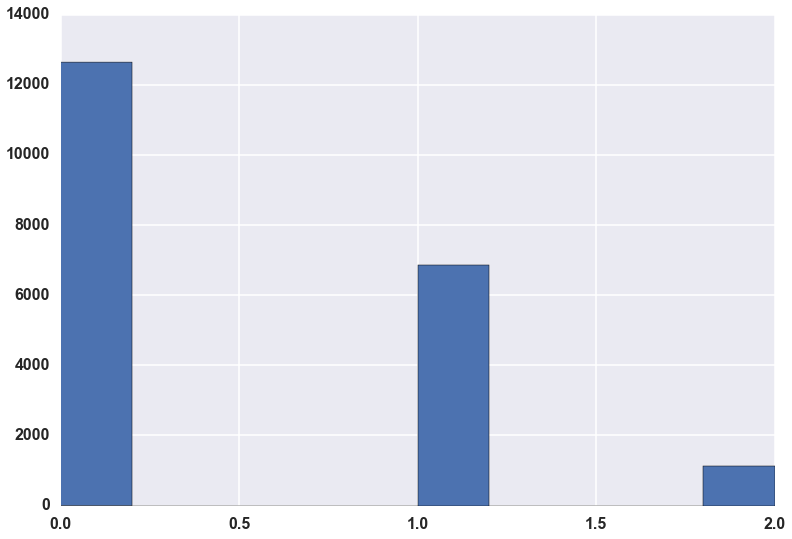

In [27]:
# class 3
temp = assign_biz_multiclass1(0.30)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))
for name, clf in zip(names, classifiers):
    scores = []
    for biz_code,biz_name in zip(business_codes,business_names):
        df_2011 = gb.get_group((2011,biz_code))
        df_2012 = gb.get_group((2012,biz_code))
        test_size = 0.4
        
        X = df_2011.ix[:,2:32]
        y = df_2012.ix[:,-1]
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
        print name+ ':' + biz_name + ':' +str(score)
    print sum(np.array(scores)>0.33)/float(len(business_codes))*100

# 3. Random forest
### Compute guess rate

In [281]:
np.average(df_all.biz_index)

0.50794573643410856

## Binary

50.0


/Users/Hongsup/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


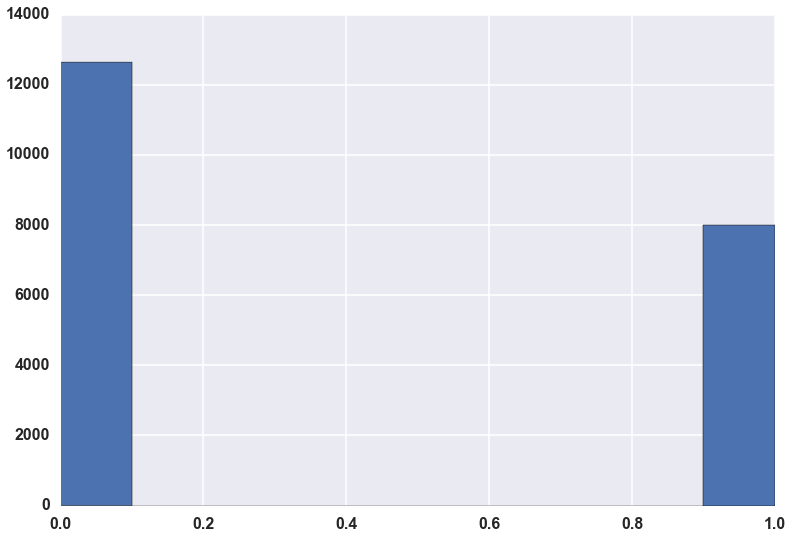

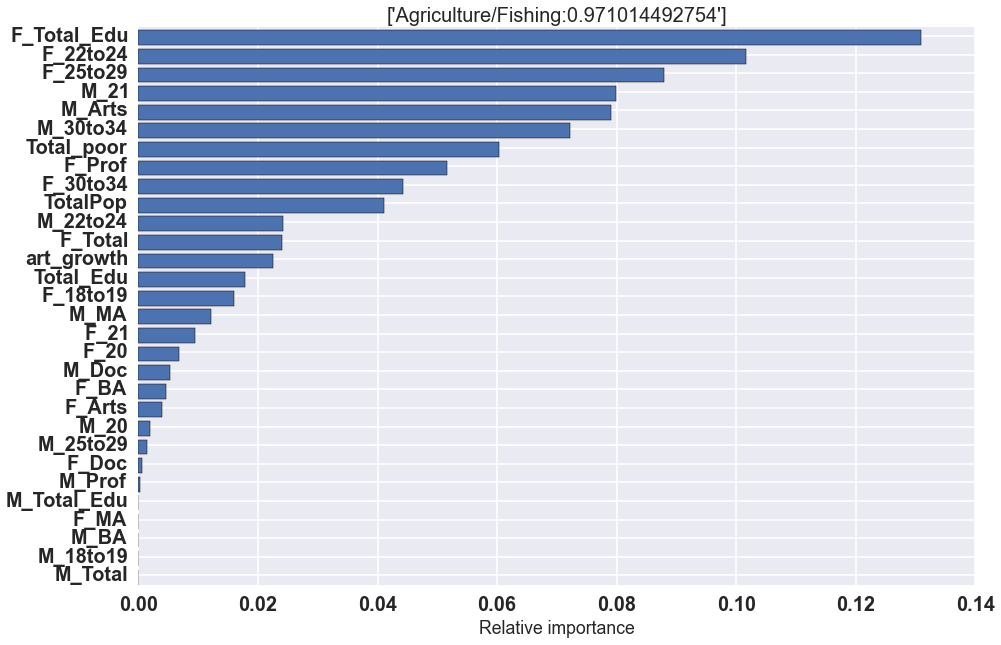

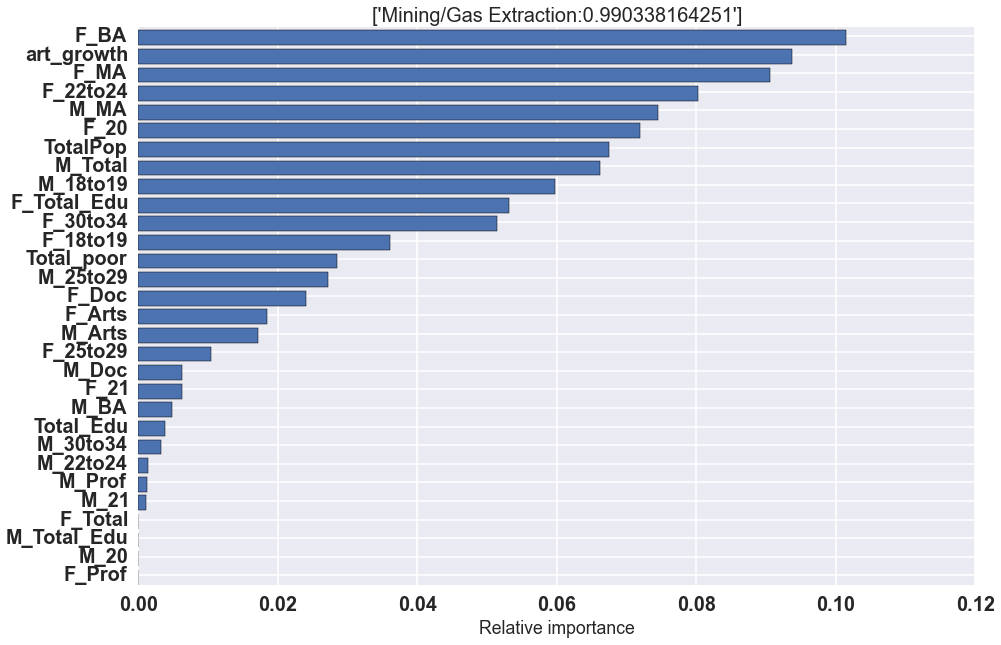

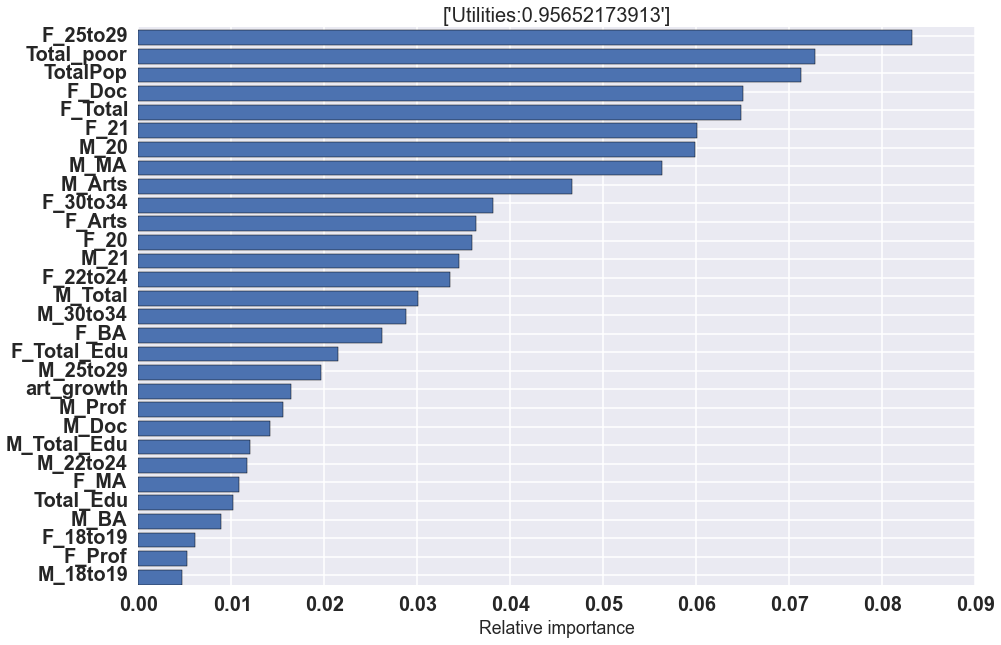

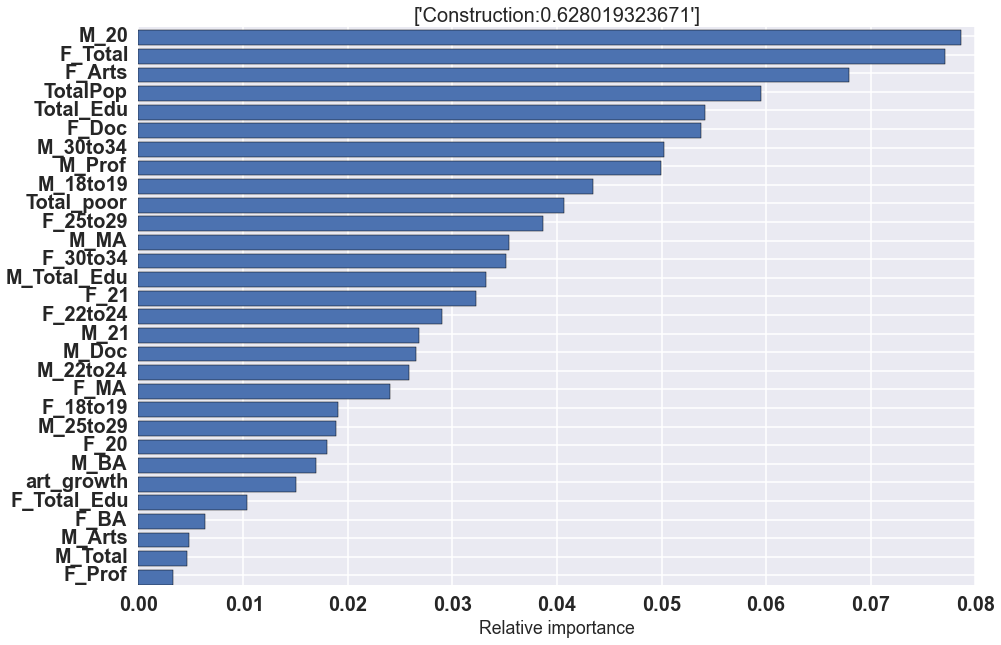

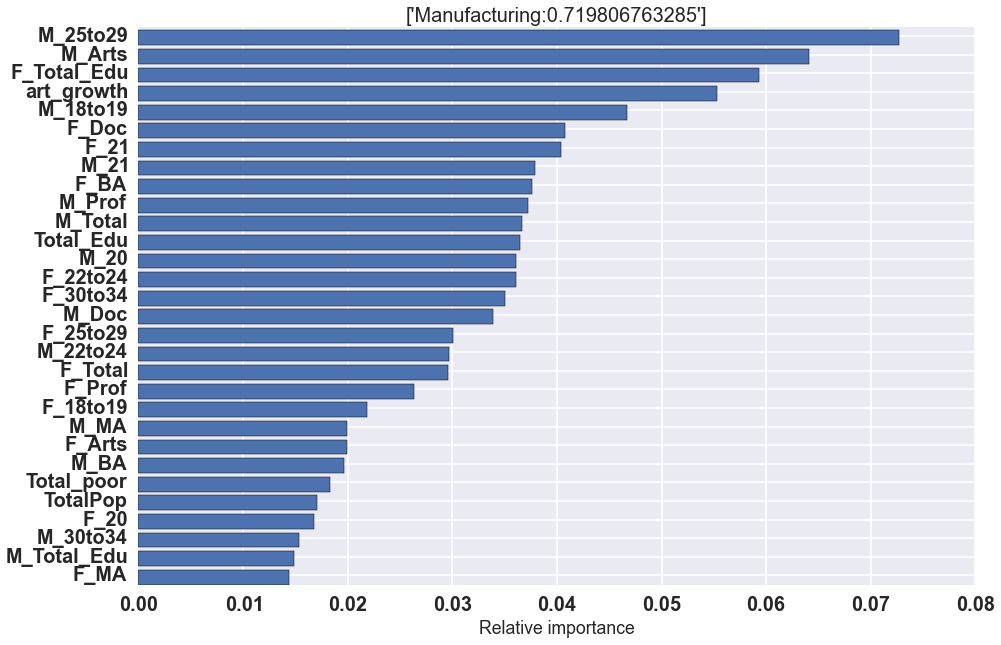

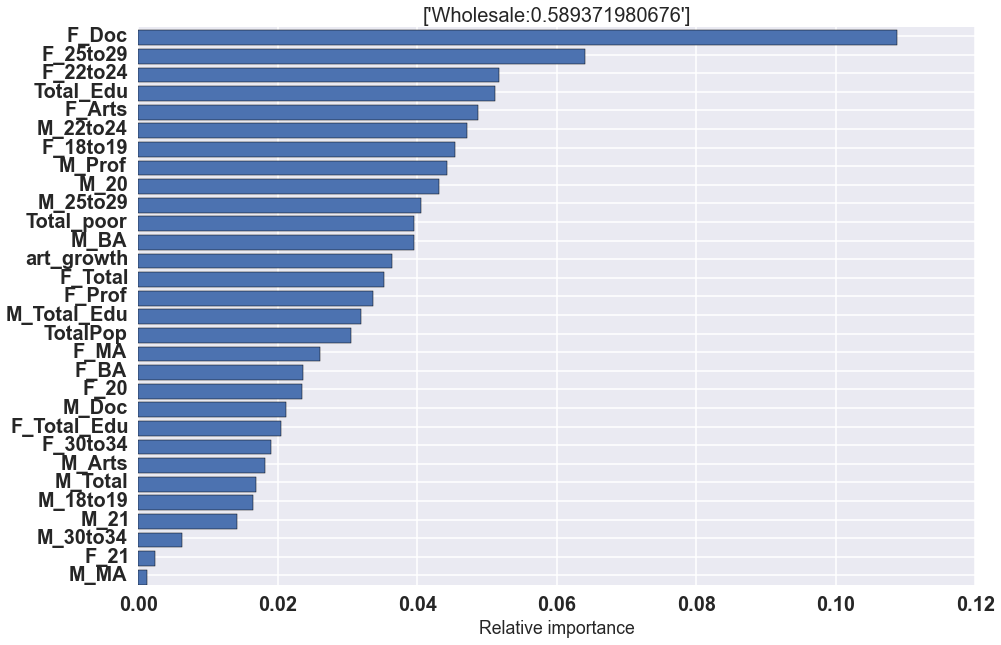

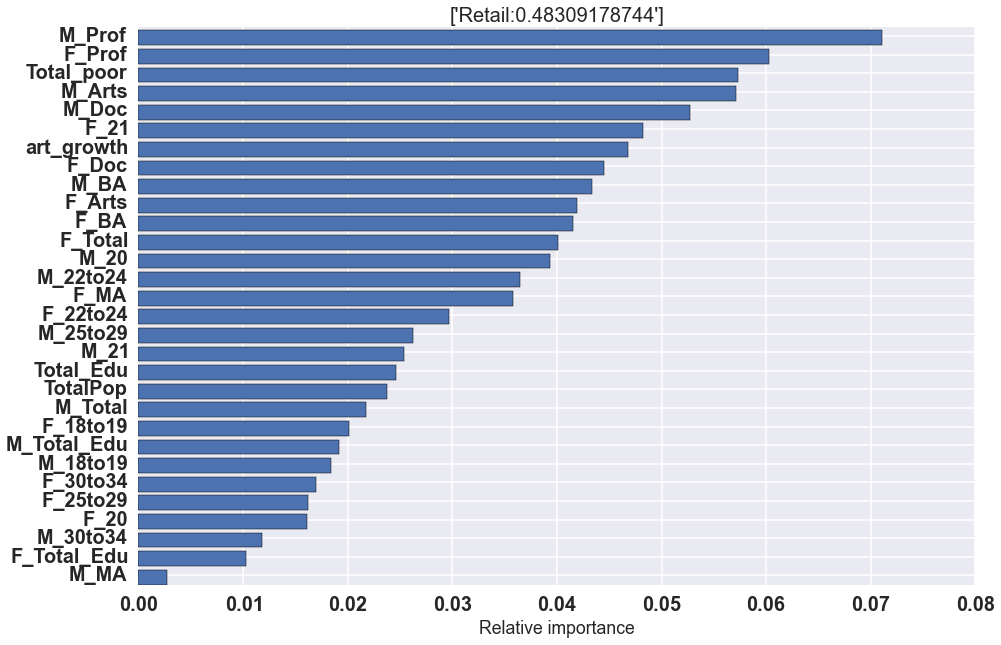

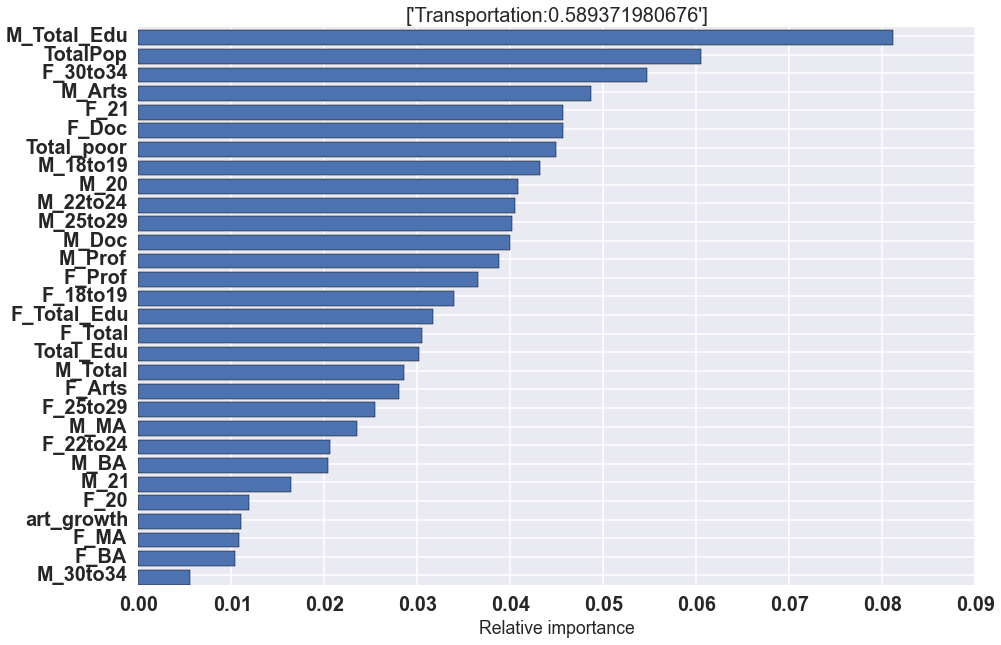

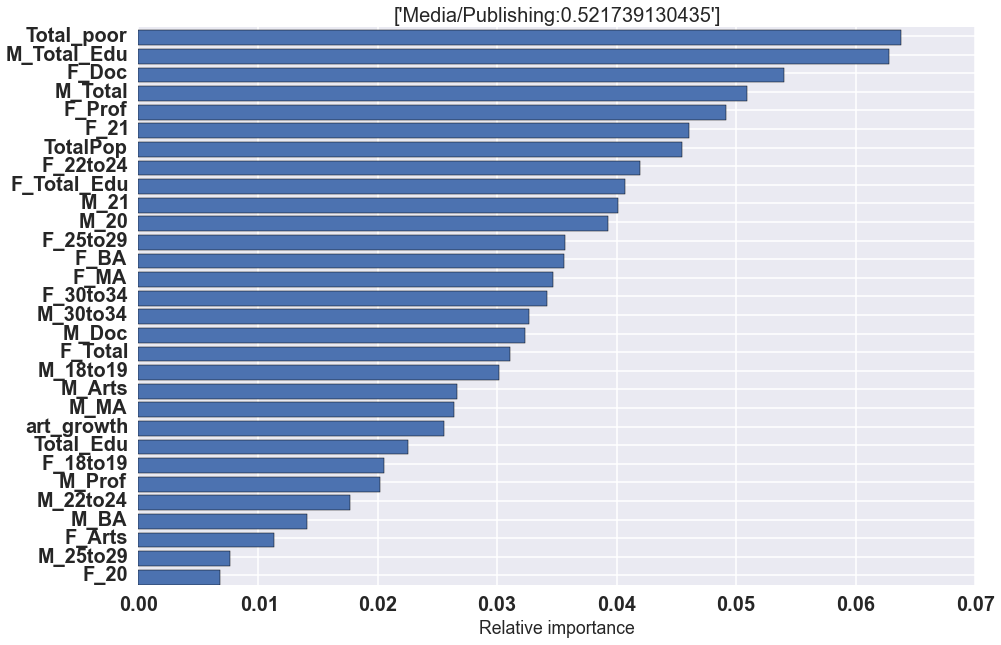

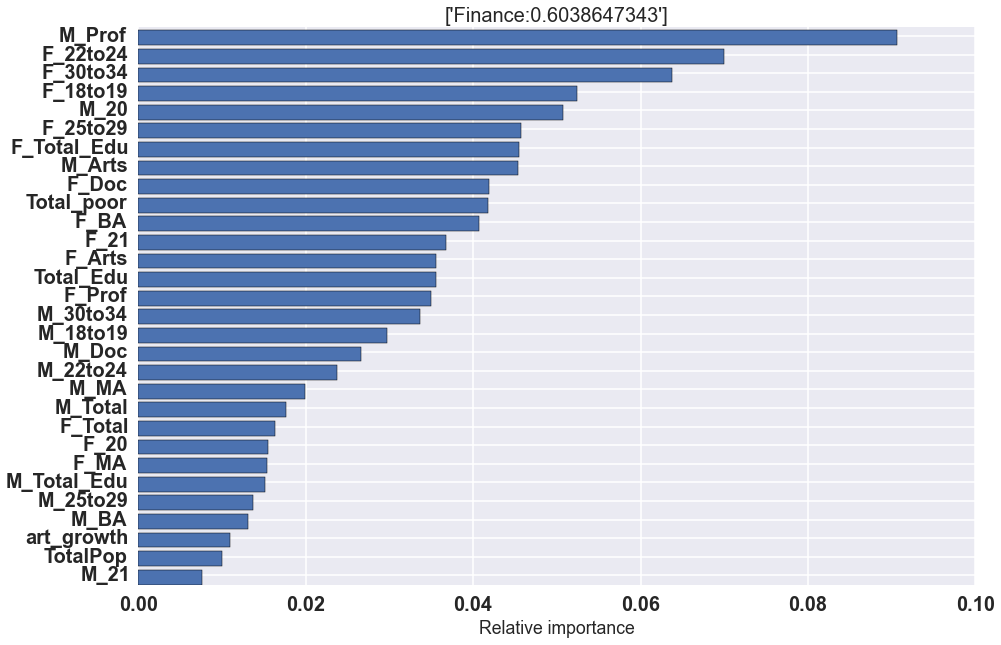

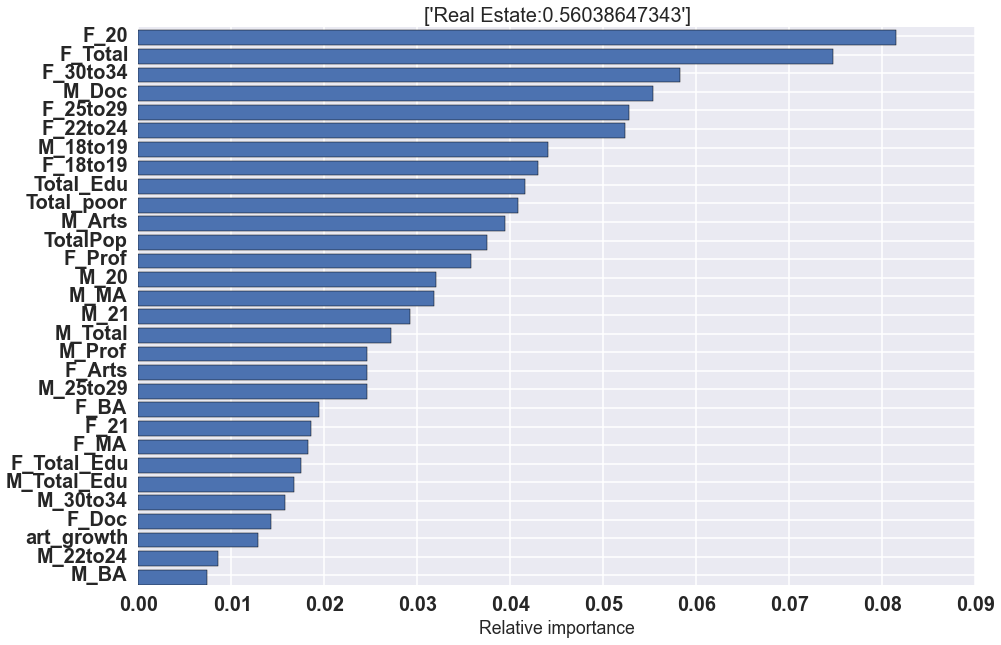

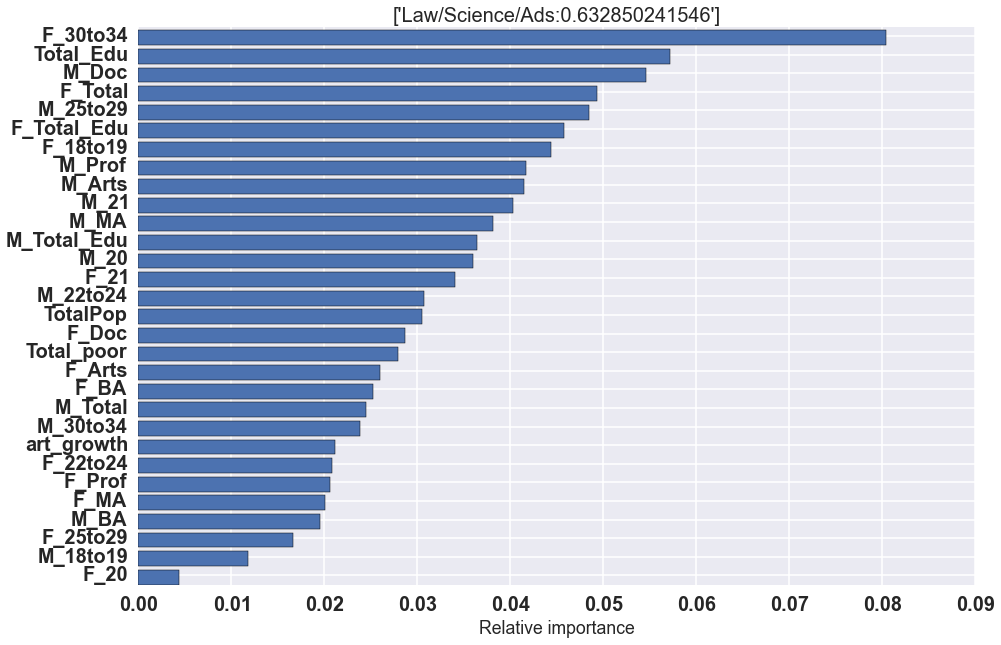

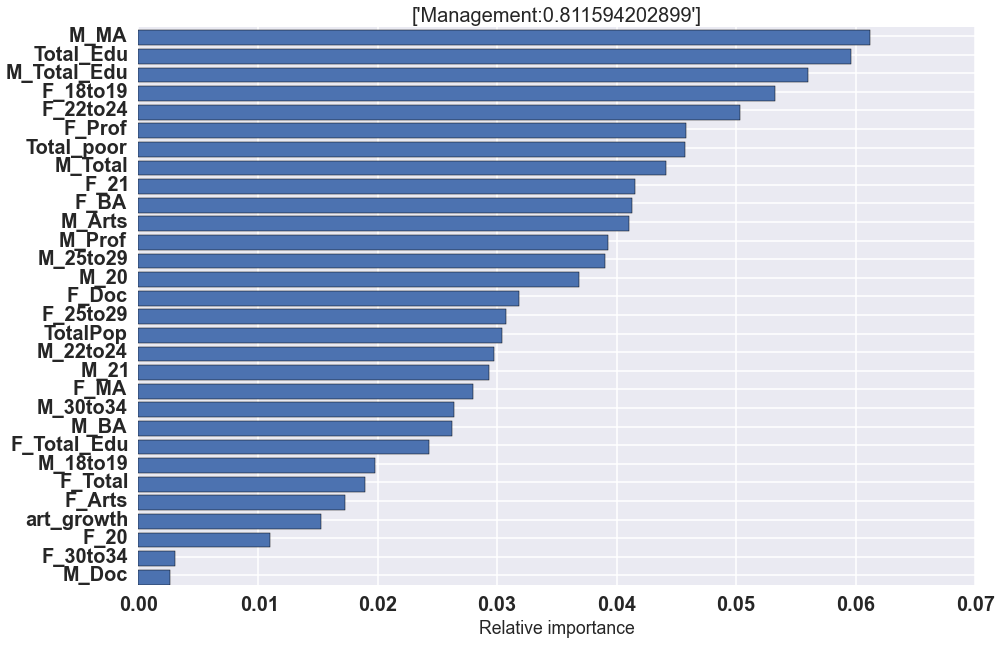

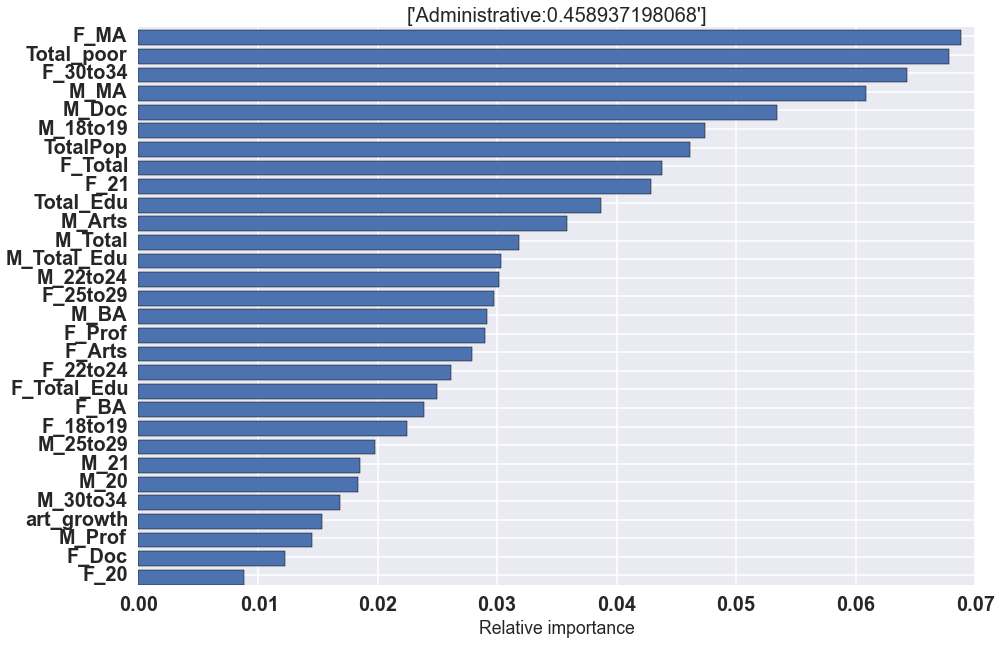

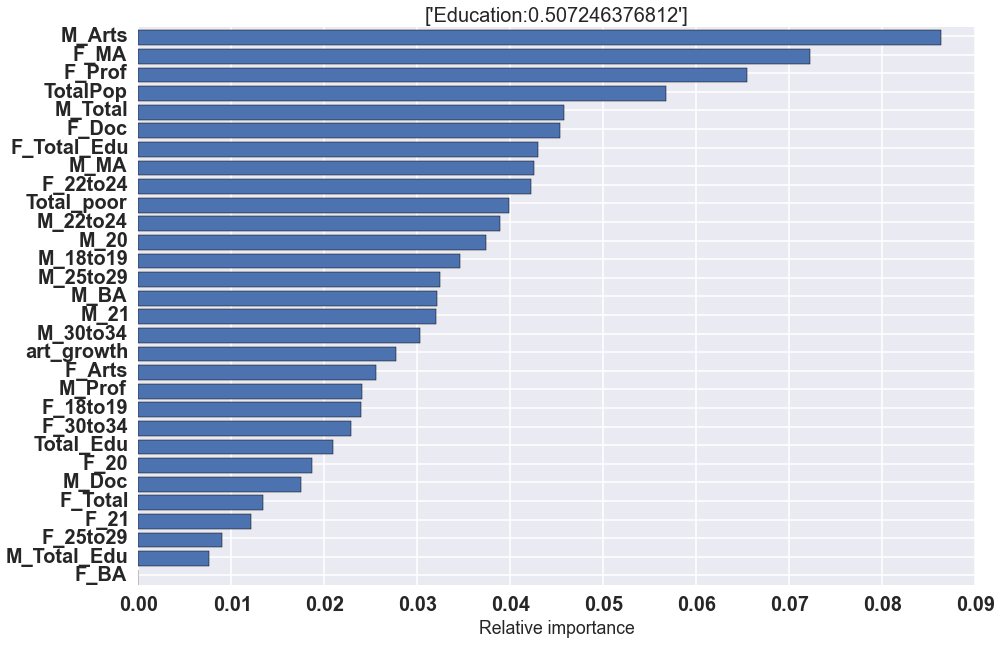

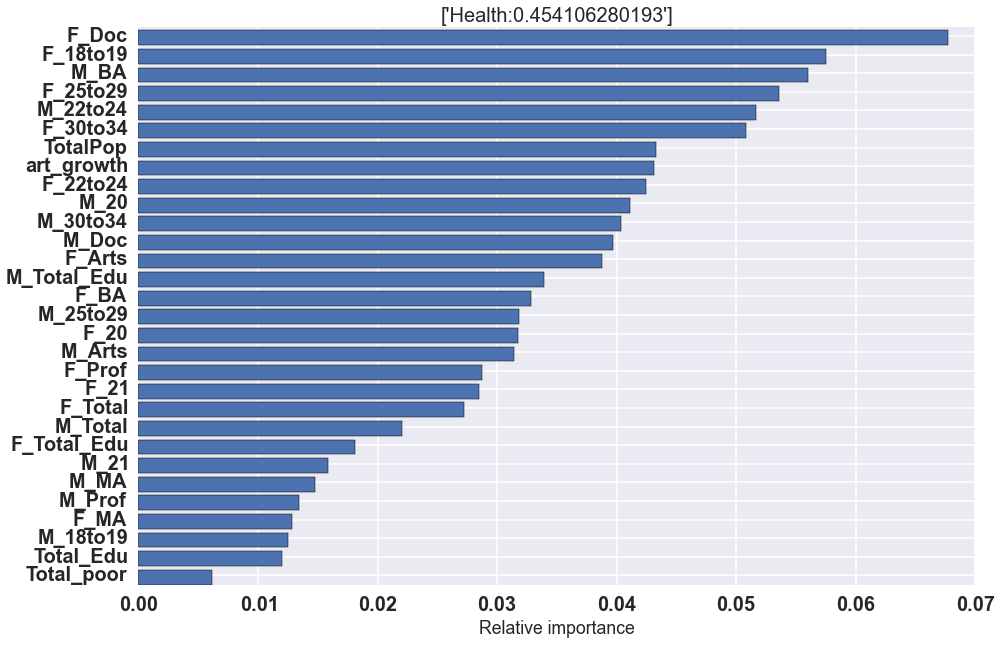

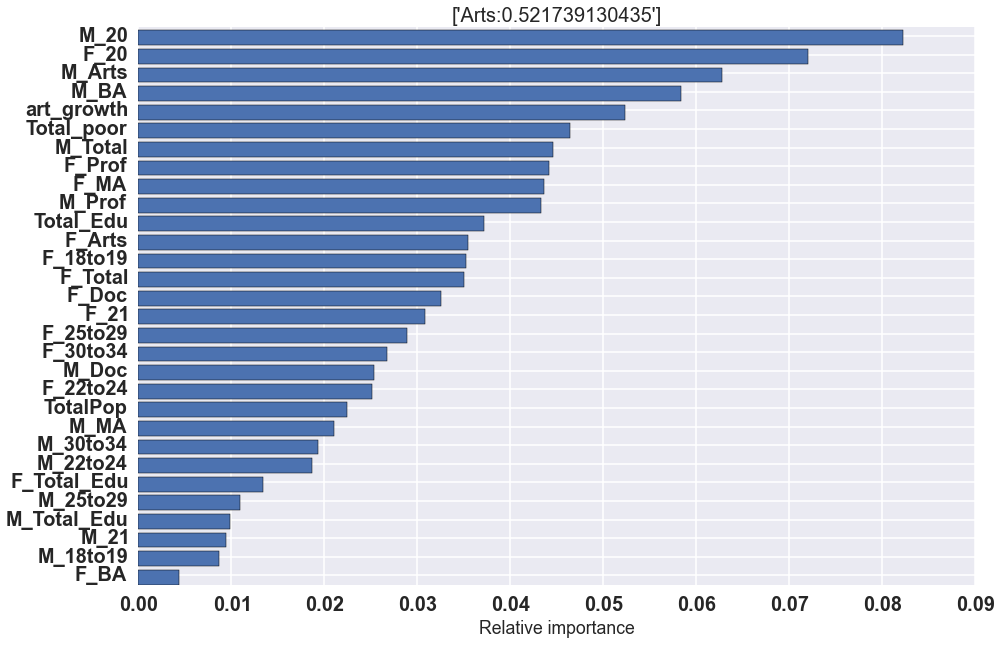

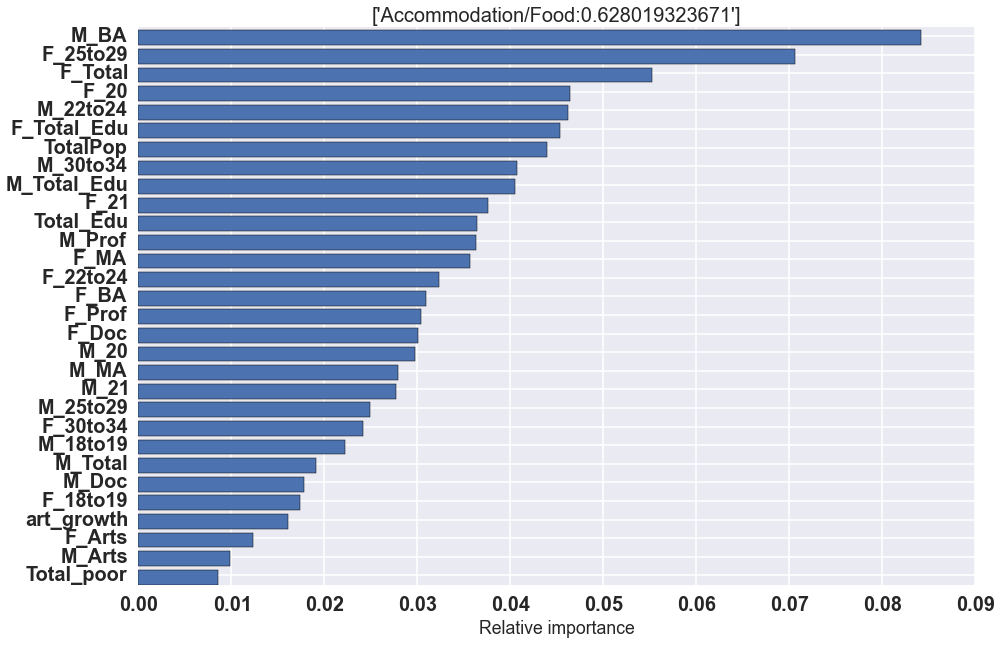

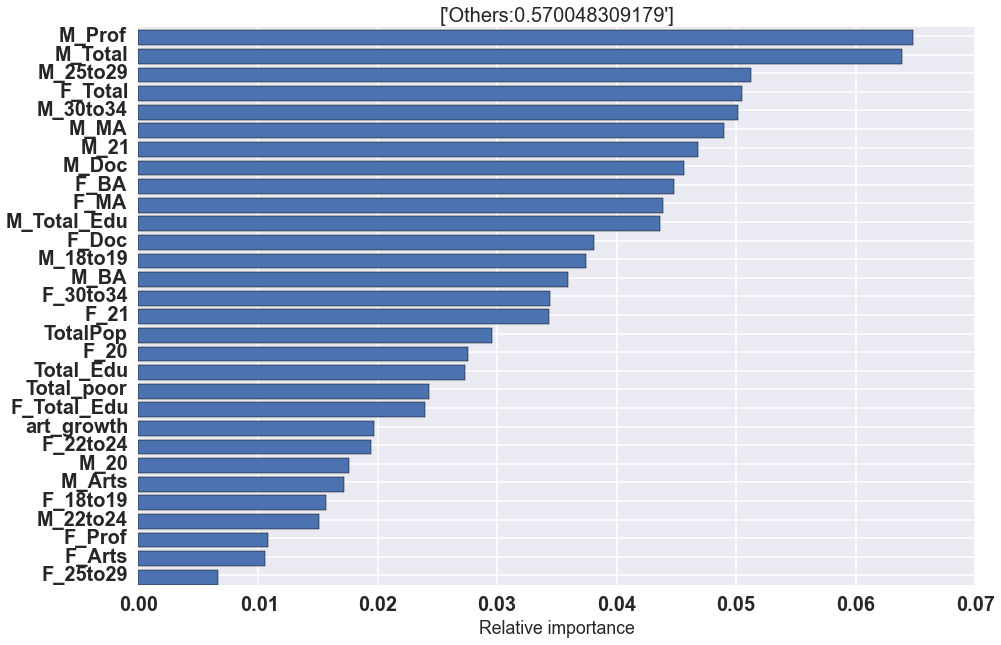

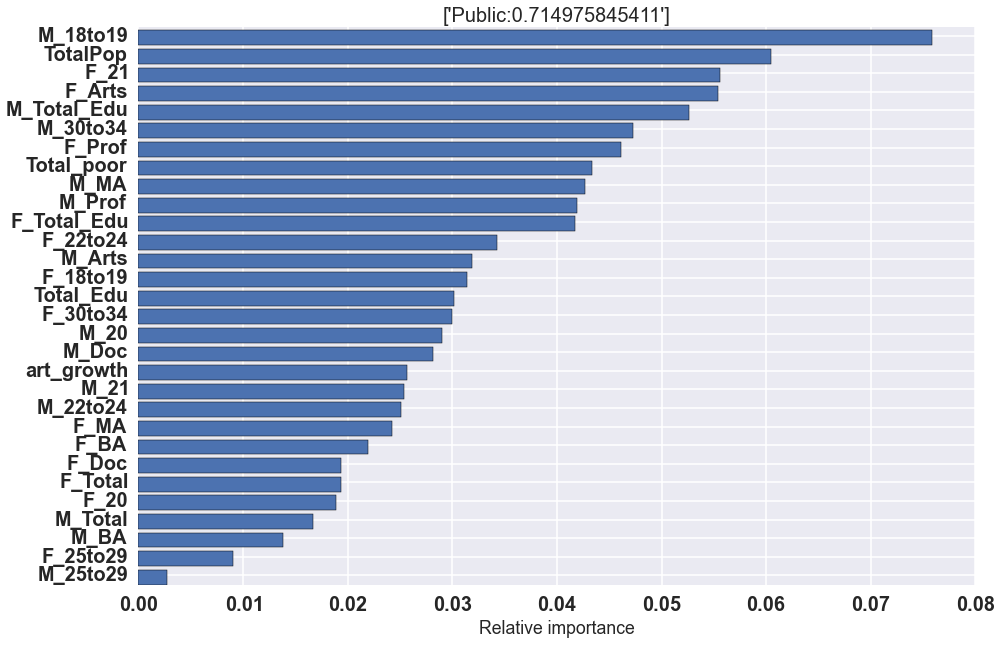

In [29]:
temp = assign_biz_binary()
df_binom = df_all
df_binom['biz_index']=pd.DataFrame(temp)
gb = df_binom.groupby(('year','business_code'))

clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
scores = []
for biz_code,biz_name in zip(business_codes,business_names):
    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4

    X = df_2011.ix[:,2:32]
    y = df_2012.ix[:,-1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
#     print biz_name + ':' +str(score)
    # evaluate feature importance
    rf_eval_feat(df_2011.columns[2:32],clf,biz_name,score)
    
print sum(np.array(scores)>0.6)/float(len(business_codes))*100

Nearest Neighbors:Agriculture/Fishing:0.971014492754
Nearest Neighbors:Mining/Gas Extraction:0.990338164251
Nearest Neighbors:Utilities:0.951690821256
Nearest Neighbors:Construction:0.410628019324
Nearest Neighbors:Manufacturing:0.661835748792
Nearest Neighbors:Wholesale:0.429951690821
Nearest Neighbors:Retail:0.48309178744
Nearest Neighbors:Transportation:0.512077294686
Nearest Neighbors:Media/Publishing:0.473429951691
Nearest Neighbors:Finance:0.468599033816
Nearest Neighbors:Real Estate:0.425120772947
Nearest Neighbors:Law/Science/Ads:0.400966183575
Nearest Neighbors:Management:0.787439613527
Nearest Neighbors:Administrative:0.410628019324
Nearest Neighbors:Education:0.381642512077
Nearest Neighbors:Health:0.43961352657
Nearest Neighbors:Arts:0.429951690821
Nearest Neighbors:Accommodation/Food:0.415458937198
Nearest Neighbors:Others:0.550724637681
Nearest Neighbors:Public:0.623188405797
30.0
Linear SVM:Agriculture/Fishing:0.971014492754
Linear SVM:Mining/Gas Extraction:0.99033816425

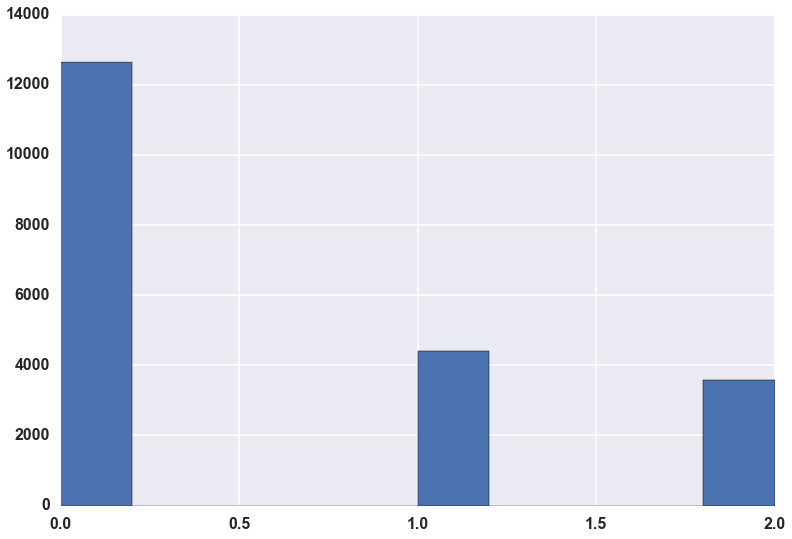

In [30]:
# class 3
temp = assign_biz_multiclass1(0.10)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))
for name, clf in zip(names, classifiers):
    scores = []
    for biz_code,biz_name in zip(business_codes,business_names):
        df_2011 = gb.get_group((2011,biz_code))
        df_2012 = gb.get_group((2012,biz_code))
        test_size = 0.4
        
        X = df_2011.ix[:,2:32]
        y = df_2012.ix[:,-1]
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
        print name+ ':' + biz_name + ':' +str(score)
    print sum(np.array(scores)>0.6)/float(len(business_codes))*100

We're settling with 0.46

### Random forest: 4 classes and predictions

In [ ]:
feature_names = df_2011.columns[2:32]

70.0


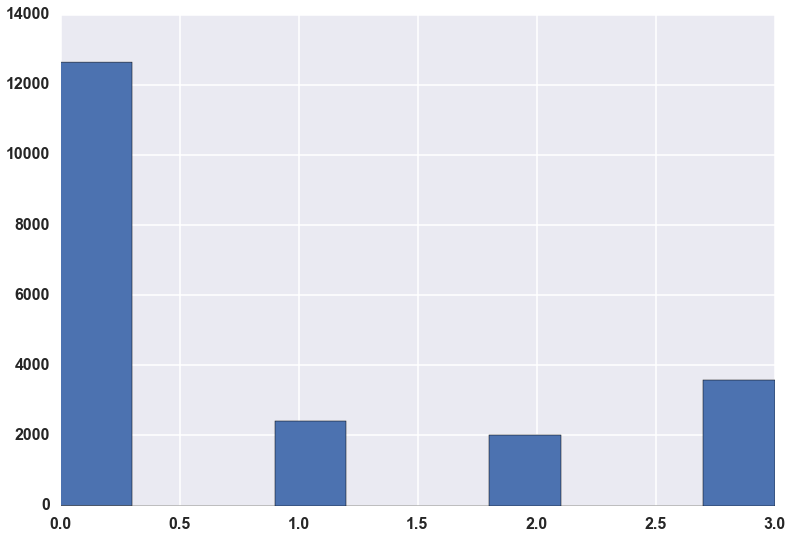

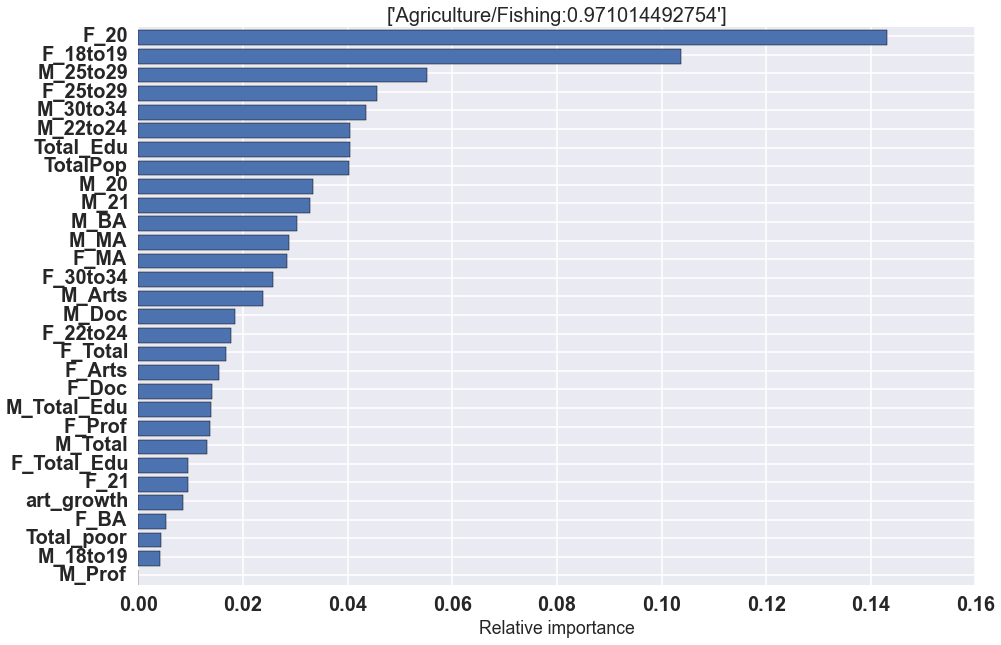

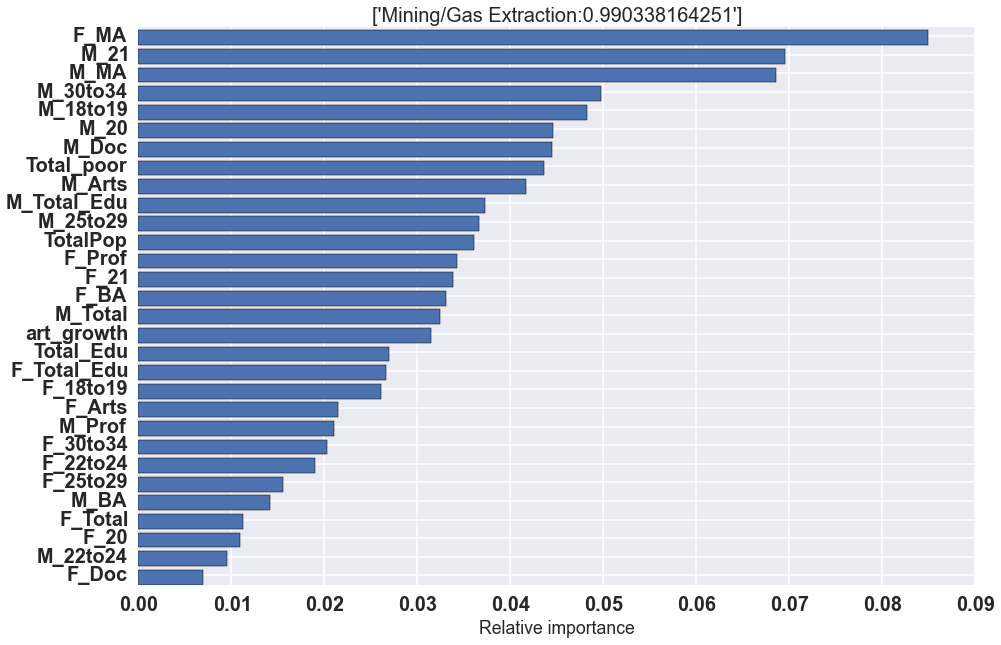

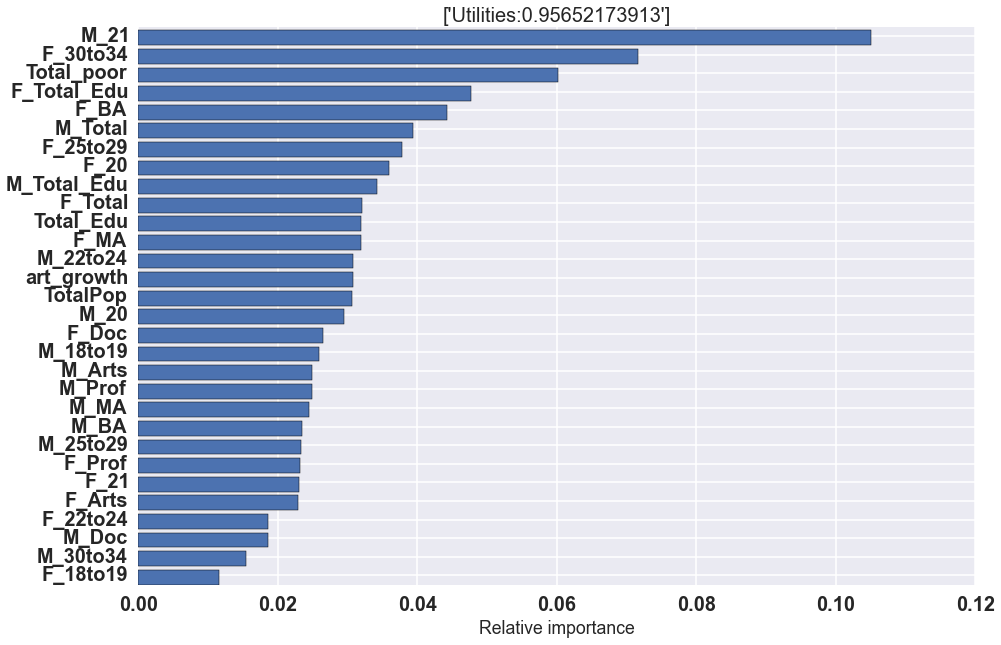

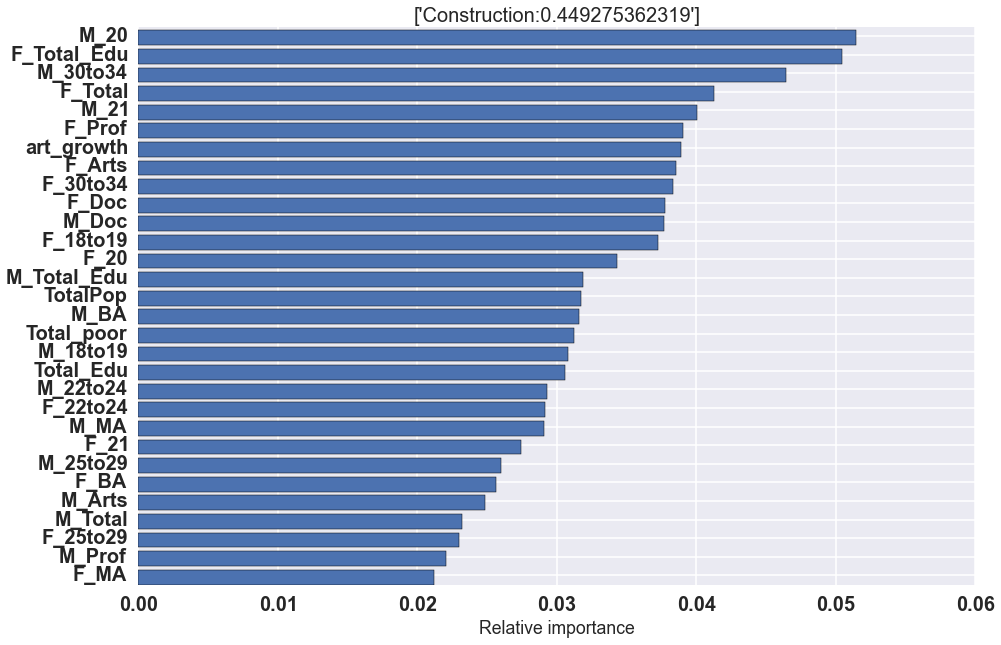

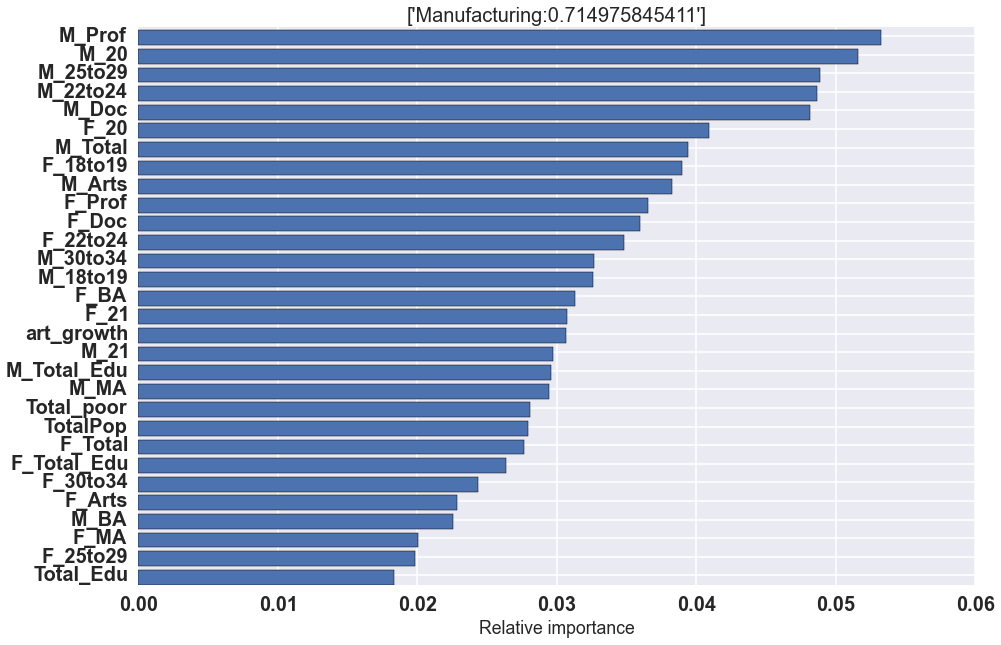

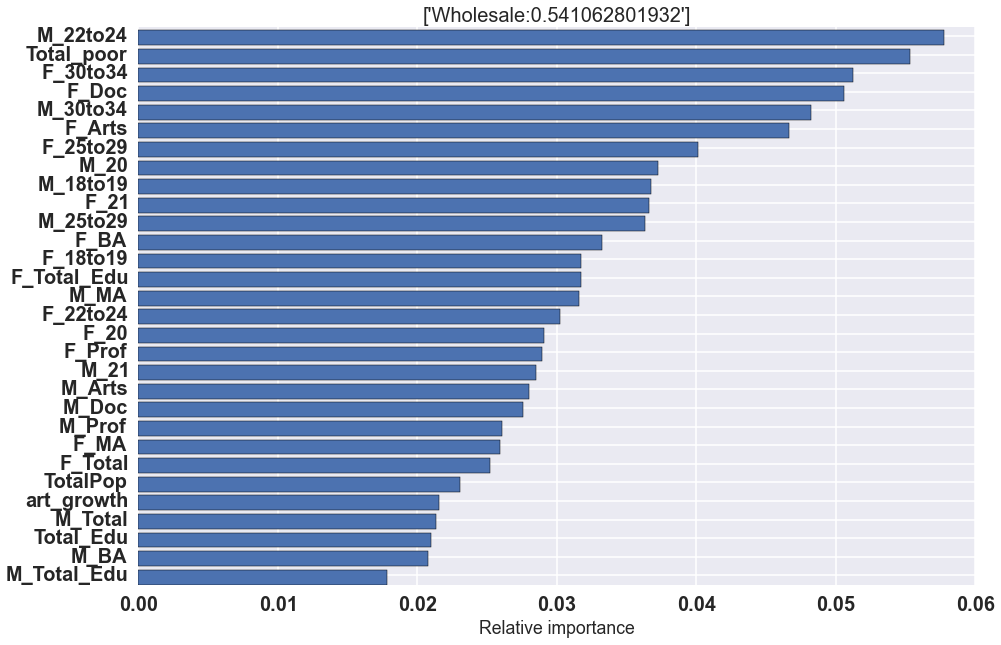

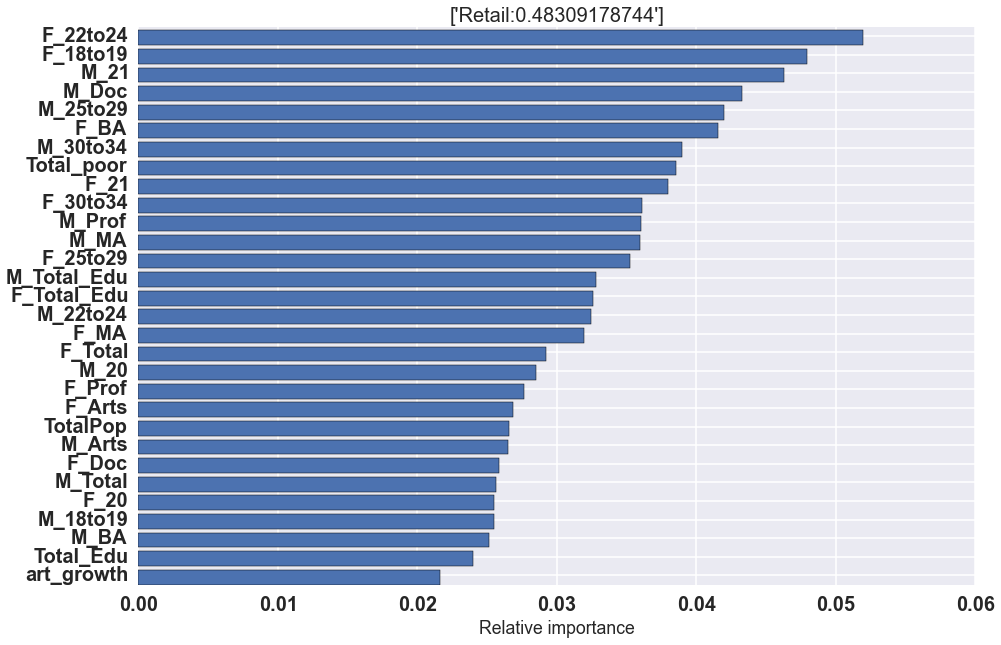

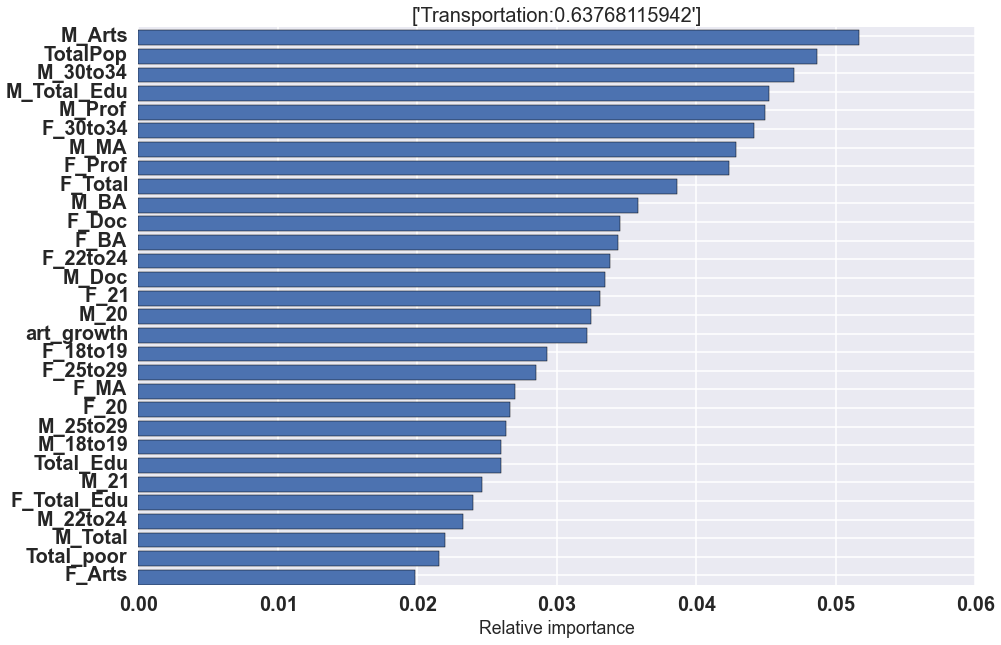

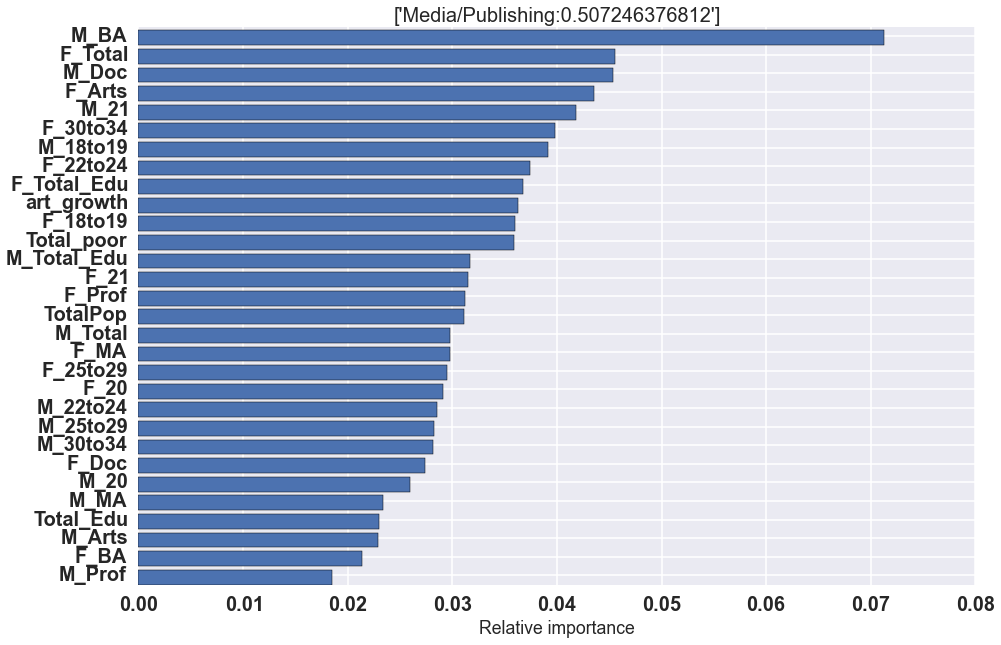

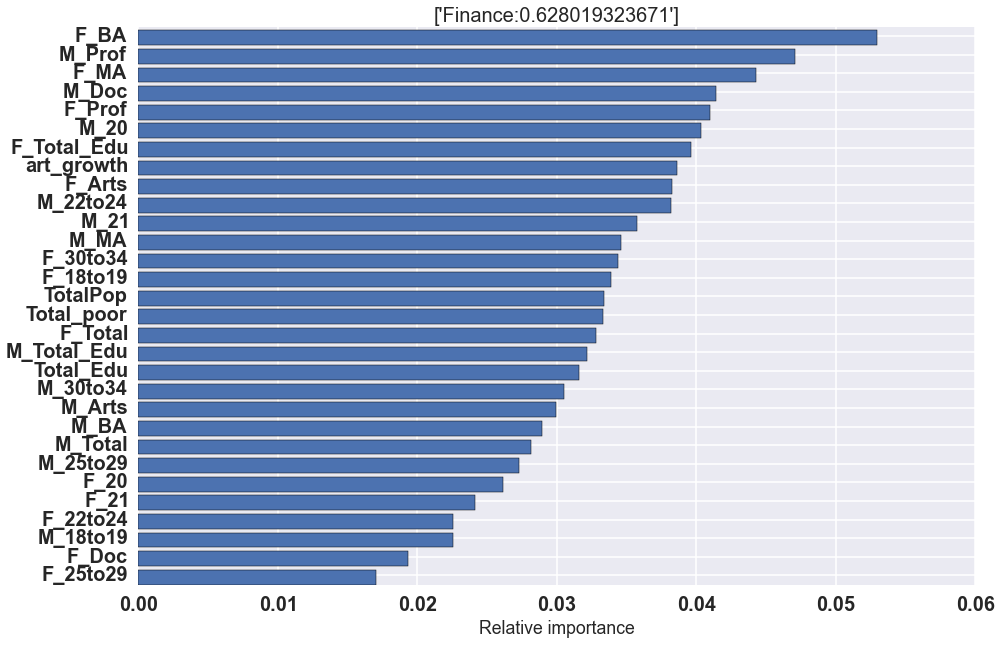

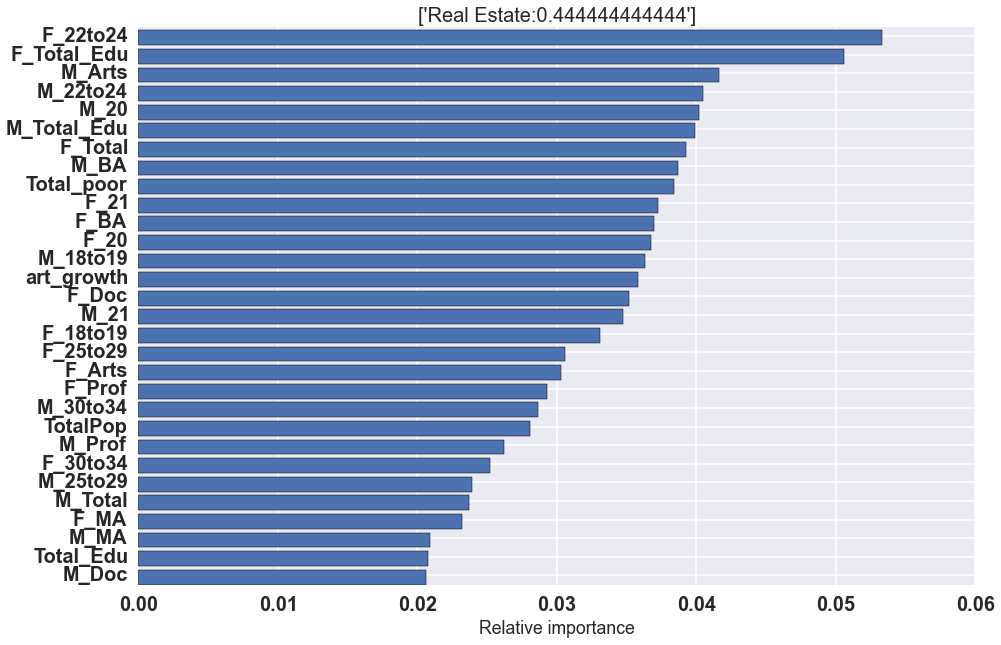

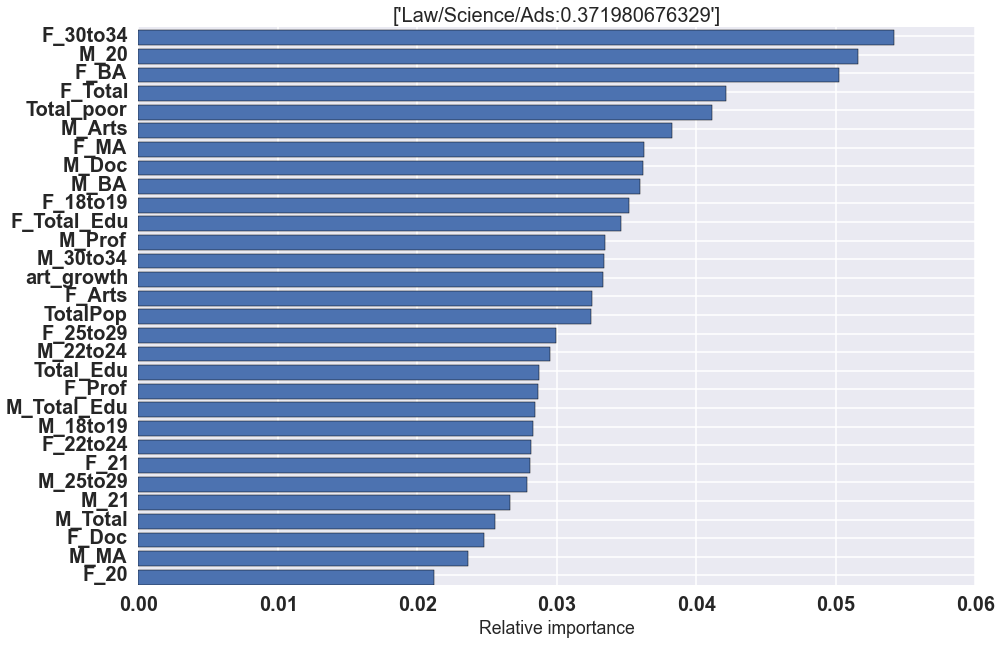

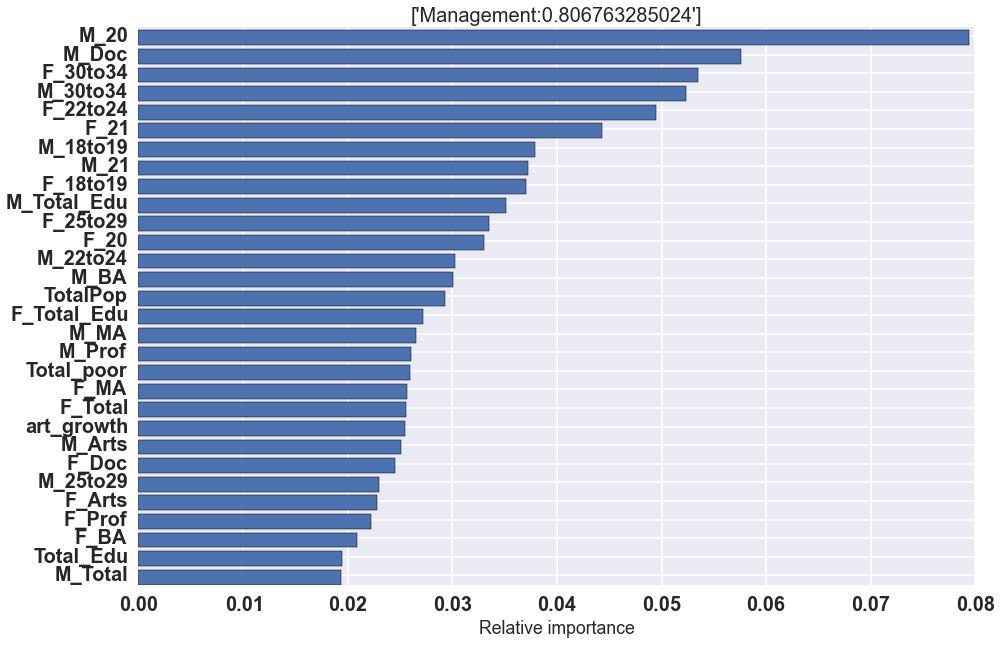

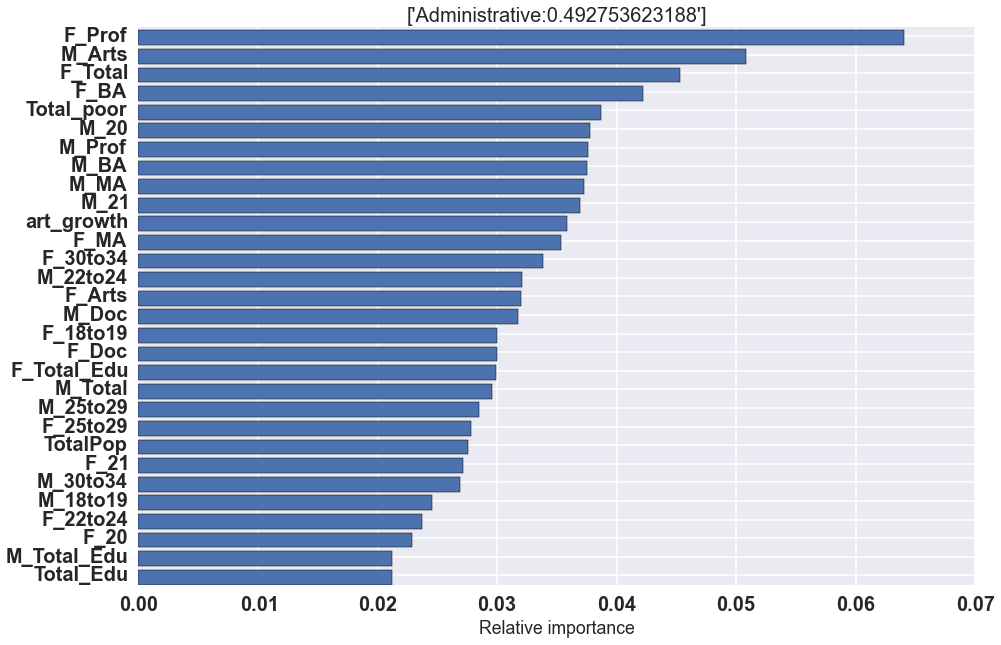

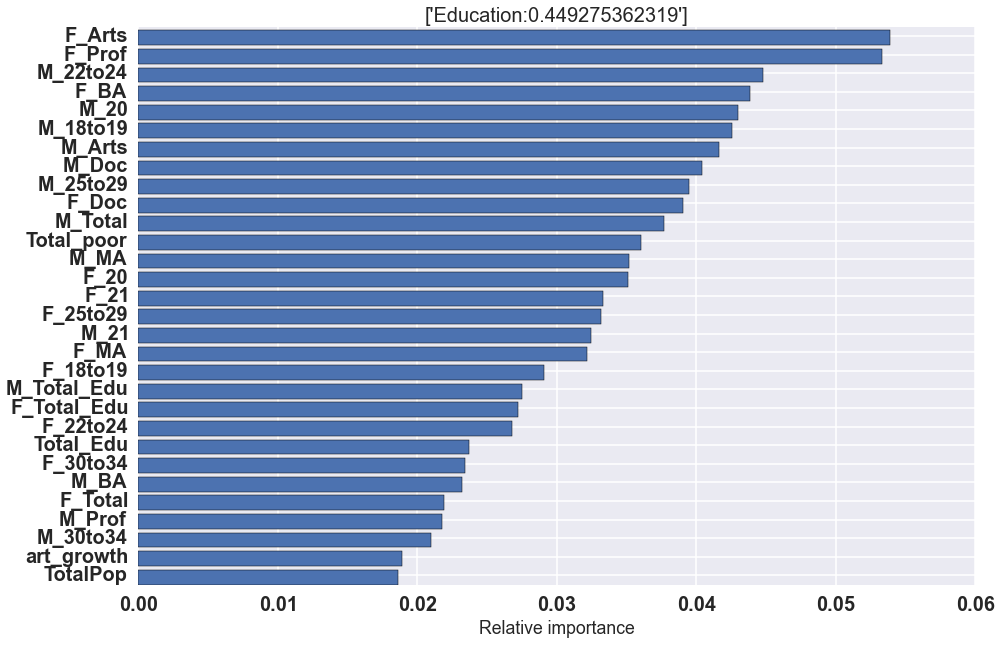

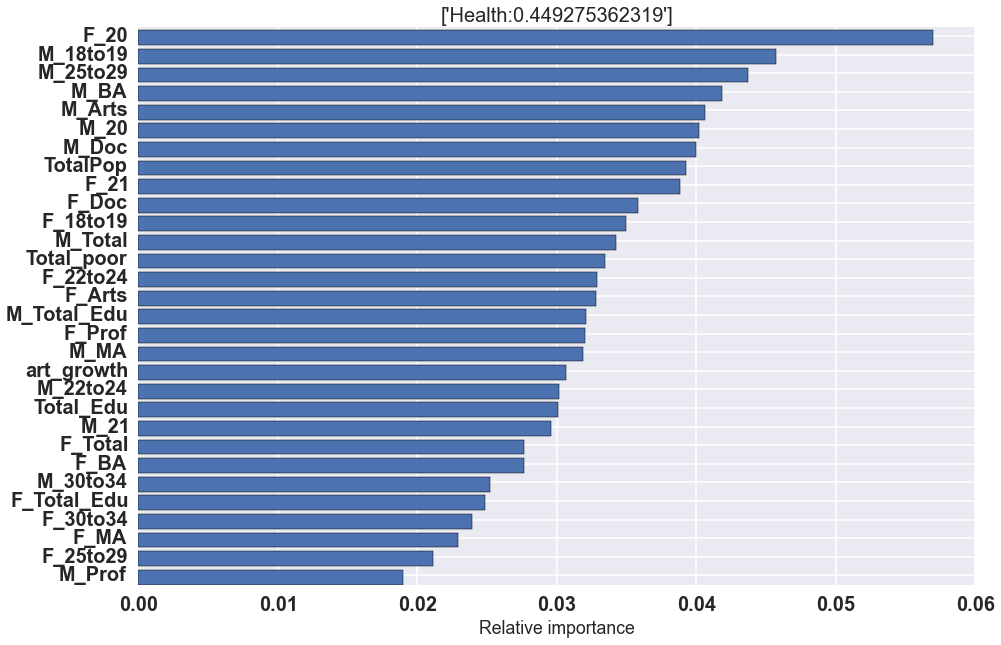

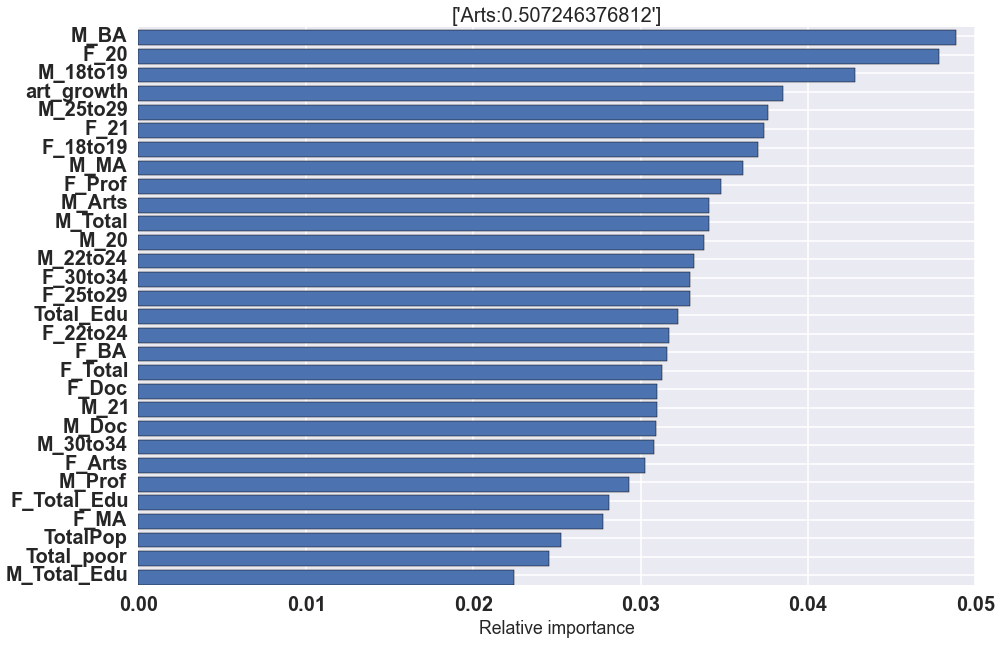

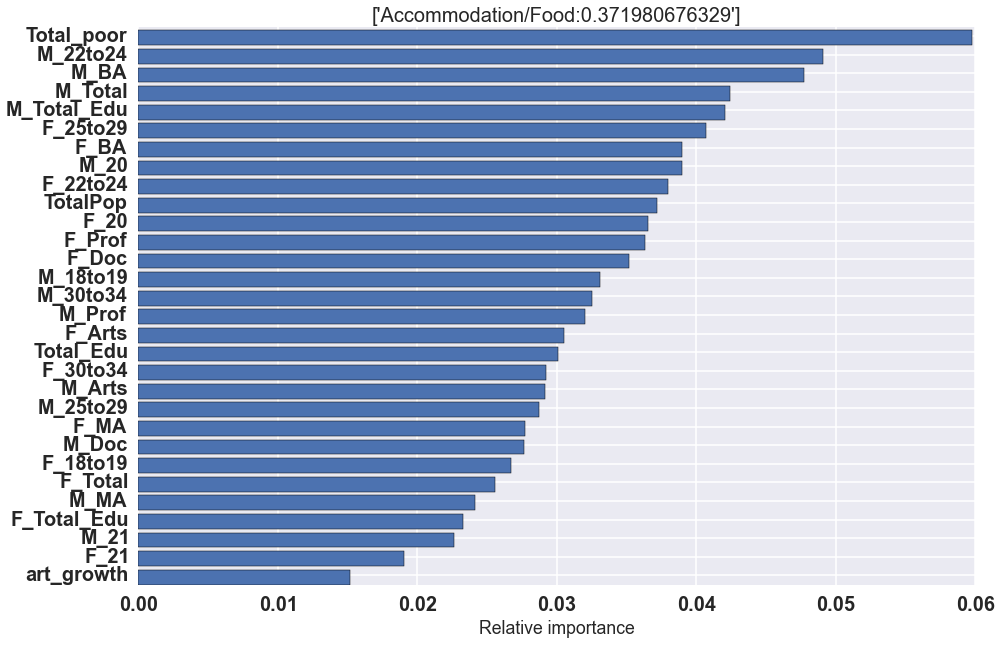

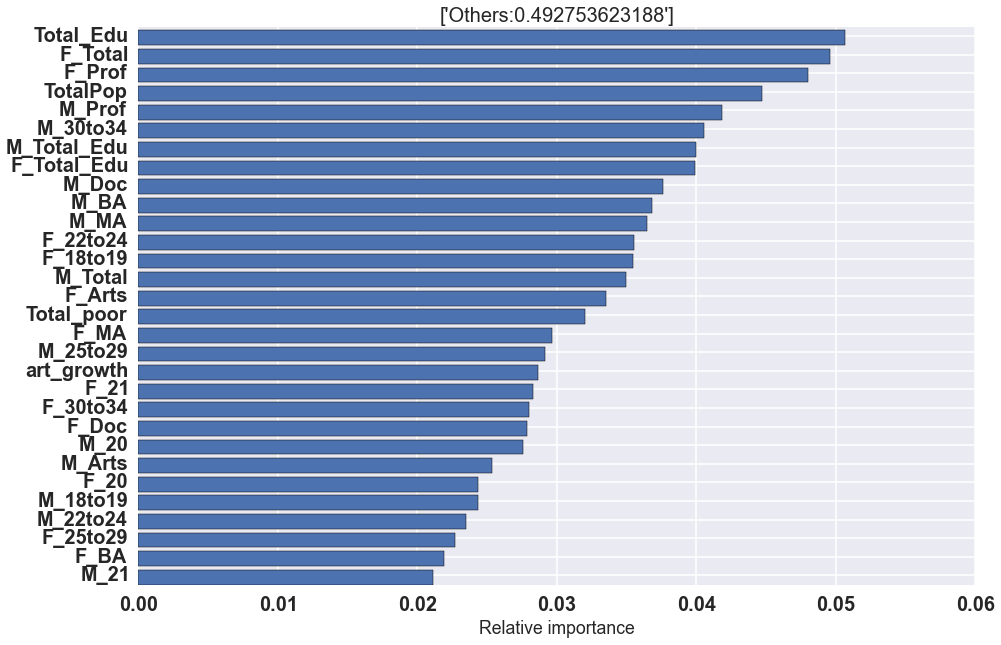

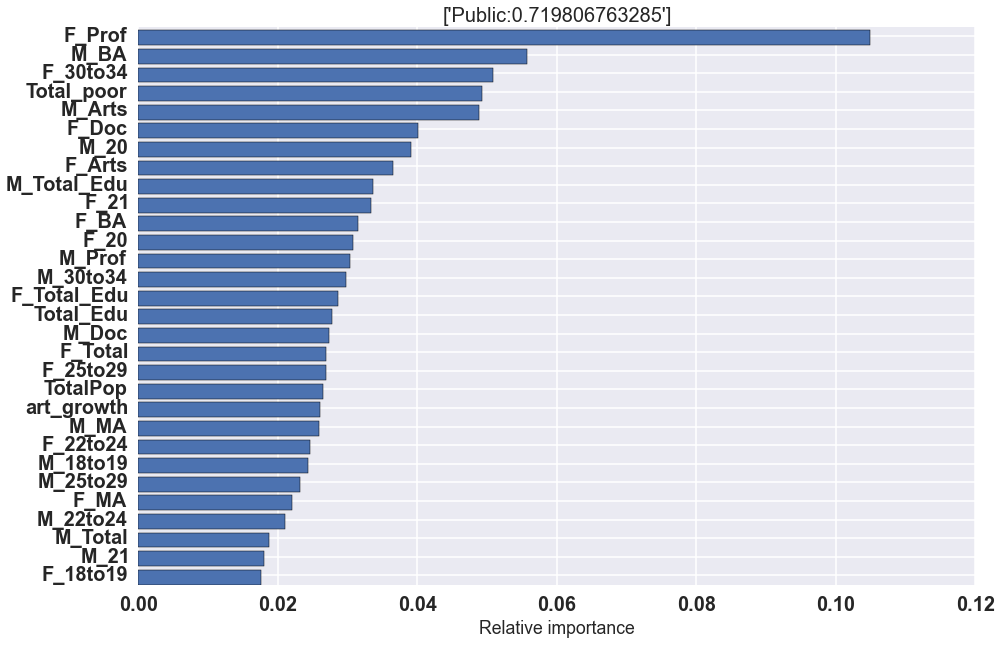

In [159]:
temp = assign_biz_multiclass2(0.05)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))

clf = RandomForestClassifier(max_depth=5, n_estimators=100)
scores = []
y_2013_list = []
art_importance = []
art_rank_list = []
for biz_code,biz_name in zip(business_codes,business_names):
    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4

    X = df_2011.ix[:,2:32]
    y = df_2012.ix[:,-1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

    # prediction
    X_2012 = df_2012.ix[:,2:32]
    y_2013 = list(clf.predict(X_2012))
    y_2013_list.append(y_2013)
    
    # evaluate feature importance
    indices = rf_eval_feat(df_2011.columns[2:32],clf,biz_name,score)

    # check the contribution of art_growth
    art_importance.append(clf.feature_importances_[-1])
    art_rank = len(feature_names)-np.arange(len(feature_names))[feature_names[indices]=='art_growth'][0]
    art_rank_list.append(art_rank)

# merge lists of list
import itertools
y_2013_merged = list(itertools.chain(*y_2013_list))
    
print sum(np.array(scores)>0.46)/float(len(business_codes))*100

## Validation: precision and recall

In [46]:
# To build confusion matrix, you need # of data points corresponding to the index
# 2. per business, cm = confusion_matrix(y_test, y_pred)
df_multinom.columns

Index([u'year', u'zip_code', u'TotalPop', u'M_Total', u'M_18to19', u'M_20',
       u'M_21', u'M_22to24', u'M_25to29', u'M_30to34', u'F_Total', u'F_18to19',
       u'F_20', u'F_21', u'F_22to24', u'F_25to29', u'F_30to34', u'Total_Edu',
       u'M_Total_Edu', u'M_BA', u'M_MA', u'M_Prof', u'M_Doc', u'F_Total_Edu',
       u'F_BA', u'F_MA', u'F_Prof', u'F_Doc', u'Total_poor', u'M_Arts',
       u'F_Arts', u'art_growth', u'business_code', u'biz_growth', u'city',
       u'biz_index'],
      dtype='object')

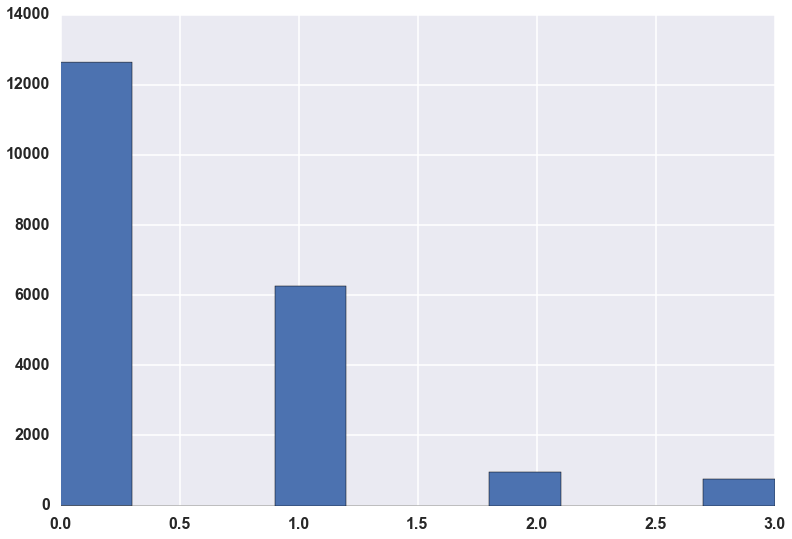

In [203]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

temp = assign_biz_multiclass2(0.20)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))

clf = RandomForestClassifier(max_depth=5, n_estimators=100)
vals = []
for biz_code,biz_name in zip(business_codes,business_names):
    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4

    X = df_2011.ix[:,2:32]
    y = df_2012.ix[:,-1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_true = y_test
    y_pred = clf.fit(X_train, y_train).predict(X_test)
#     vals.append(metrics.f1_score(y_true, y_pred, average=None))
    vals.append(metrics.precision_recall_fscore_support(y_test, y_pred, beta = 0.9, average=None))


In [213]:
# vals[i]: biz
# vals[i][2]: F1 score
# vals[i][0]: precision (precision is more important in this case)
# maximum precision = no false positive
# vals[i][3]: weights
vals_weighted = []
for i in range(len(vals)):
    vals_weighted.append(sum(vals[i][2]*vals[i][3]/sum(vals[i][3])))

In [284]:
# use bootstrap to evaluate the classifier
temp = assign_biz_multiclass2(0.05)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))

clf = RandomForestClassifier(max_depth=5, n_estimators=100)
scores = []
y_2013_list = []
for biz_code,biz_name in zip(business_codes,business_names):
    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4

    X = df_2011.ix[:,2:32]
    y = df_2012.ix[:,-1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

    # prediction
    X_2012 = df_2012.ix[:,2:32]
    y_2013 = list(clf.predict(X_2012))
    y_2013_list.append(y_2013)
    
    # evaluate feature importance
    indices = rf_eval_feat(df_2011.columns[2:32],clf,biz_name,score)

    # check the contribution of art_growth
    art_importance.append(clf.feature_importances_[-1])
    art_rank = len(feature_names)-np.arange(len(feature_names))[feature_names[indices]=='art_growth'][0]
    art_rank_list.append(art_rank)

# merge lists of list
import itertools
y_2013_merged = list(itertools.chain(*y_2013_list))
    
print sum(np.array(scores)>0.46)/float(len(business_codes))*100

year  zip_code  TotalPop   M_Total  M_18to19     M_20  M_21  M_22to24  \
0  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
1  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
2  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
3  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   
4  2011     21201 -0.018745  0.025664  0.076923  0.25641  -0.5   0.08316   

   M_25to29  M_30to34    ...        F_Prof     F_Doc  Total_poor    M_Arts  \
0  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
1  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
2  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
3  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   
4  0.031599   0.21978    ...     -0.132743 -0.020979   -0.000169  0.291925   

     F_Arts  art_growth  business_code  biz_growth       city  biz_index  
0 -0.109804    0.068309             11    0.000000  Baltimore          0  
1 -0.109804    0.068309             21    0.000000  Baltimore          0  
2 -0.109804    0.068309             22    0.000000  Baltimore          0  
3 -0.109804    0.068309             23    0.052632  Baltimore          1  
4 -0.109804    0.068309             30   -0.300000  Baltimore          0  

[5 rows x 36 columns]

In [282]:
vals[0][3]

array([201,   1,   3,   2])

In [214]:
vals_weighted

[0.95526022175899972,
 0.98502875176359883,
 0.93308906546236936,
 0.5340412391292424,
 0.58375360006261756,
 0.46410695128099444,
 0.52205932920088793,
 0.50111256487675793,
 0.42979651612648601,
 0.4953686762616204,
 0.4577668443287275,
 0.50230439430726892,
 0.7124794406879108,
 0.42170717261363178,
 0.2779842491959032,
 0.45814997537024282,
 0.35458590873907853,
 0.60495018236922204,
 0.60296083824453095,
 0.59827844372230998]

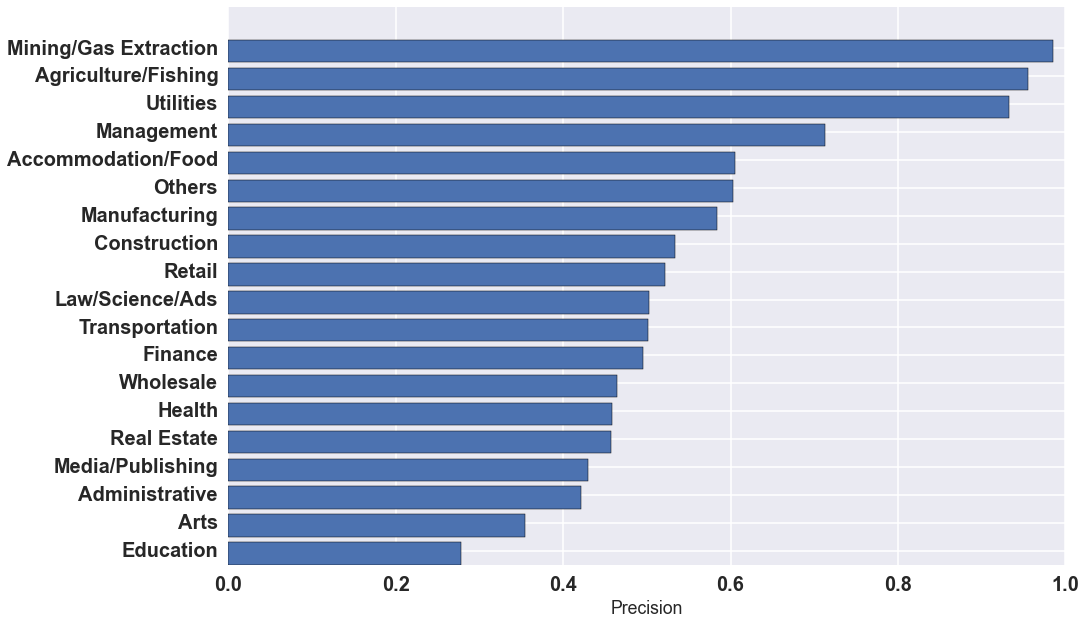

In [215]:
fig = plt.figure(figsize=(15,10))
# sort importances
indices = np.argsort(vals_weighted[:-1])
# plot as bar chart
plt.barh(np.arange(len(business_names[:-1])), np.array(vals_weighted)[indices])
plt.yticks(np.arange(len(business_names[:-1])) + 0.5, np.array(business_names)[indices])
_ = plt.xlabel('Precision')
# plt.title([title + ':' + str(score)],fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

## Art importance: absolute

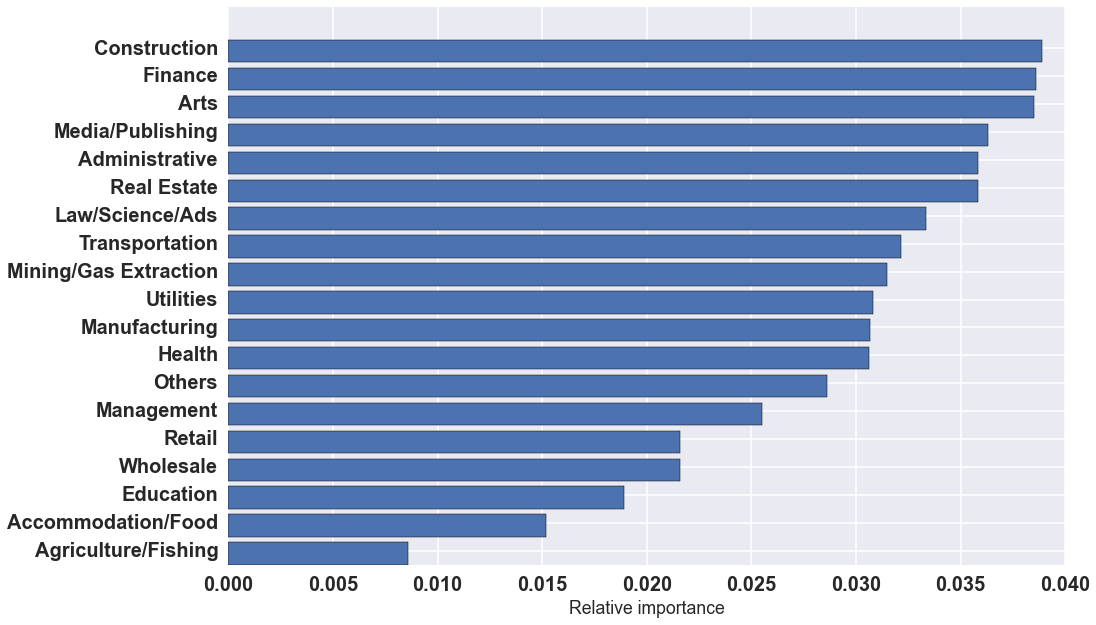

In [279]:
fig = plt.figure(figsize=(15,10))
# sort importances
indices = np.argsort(art_importance[:-1])
# plot as bar chart
plt.barh(np.arange(len(business_names[:-1])), np.array(art_importance)[indices])
plt.yticks(np.arange(len(business_names[:-1])) + 0.5, np.array(business_names)[indices])
_ = plt.xlabel('Relative importance')
# plt.title([title + ':' + str(score)],fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

## Art importance: rank

In [523]:
art_rank_list

[28, 22, 17, 9, 25, 25, 14, 21, 6, 28, 8, 11, 16, 11, 24, 12, 18, 28, 29, 28]

In [529]:
np.arange(len(business_names[:-10]))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [536]:
np.array(art_rank_list[:-10])

array([28, 22, 17,  9, 25, 25, 14, 21,  6, 28])

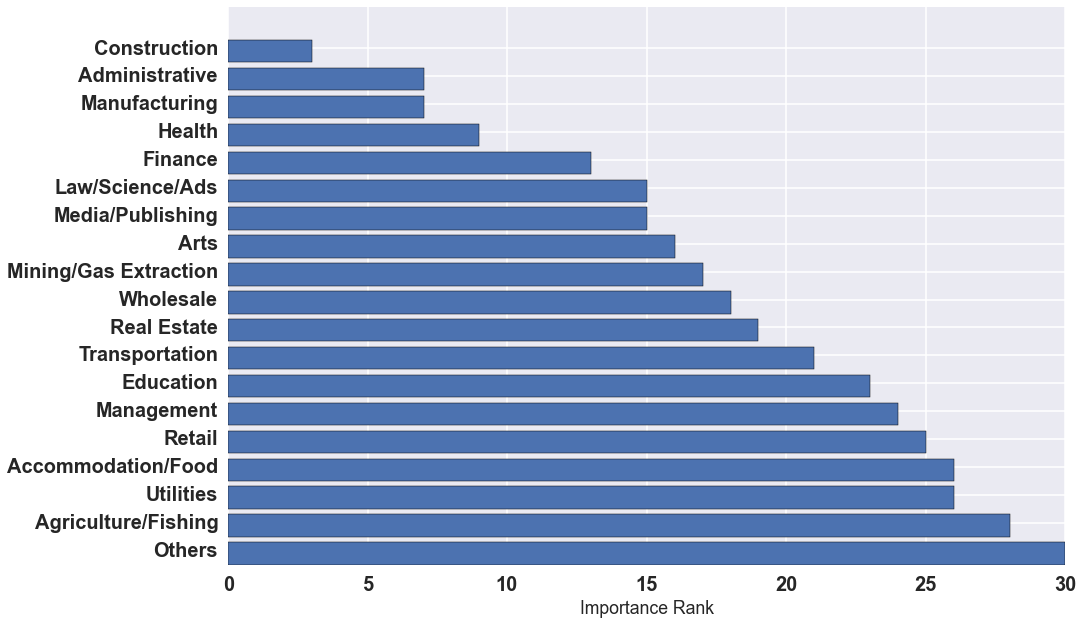

In [35]:
fig = plt.figure(figsize=(15,10))
# sort importances (descending)
indices = np.array(art_rank_list[:-1]).argsort()[::-1]
# indices = np.argsort(art_rank_list[:-1])
# plot as bar chart
plt.barh(np.arange(len(business_names[:-1])), np.array(art_rank_list[:-1])[indices])
plt.yticks(np.arange(len(business_names[:-1])) + 0.5, np.array(business_names[:-1])[indices])
_ = plt.xlabel('Importance Rank')
# plt.title([title + ':' + str(score)],fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

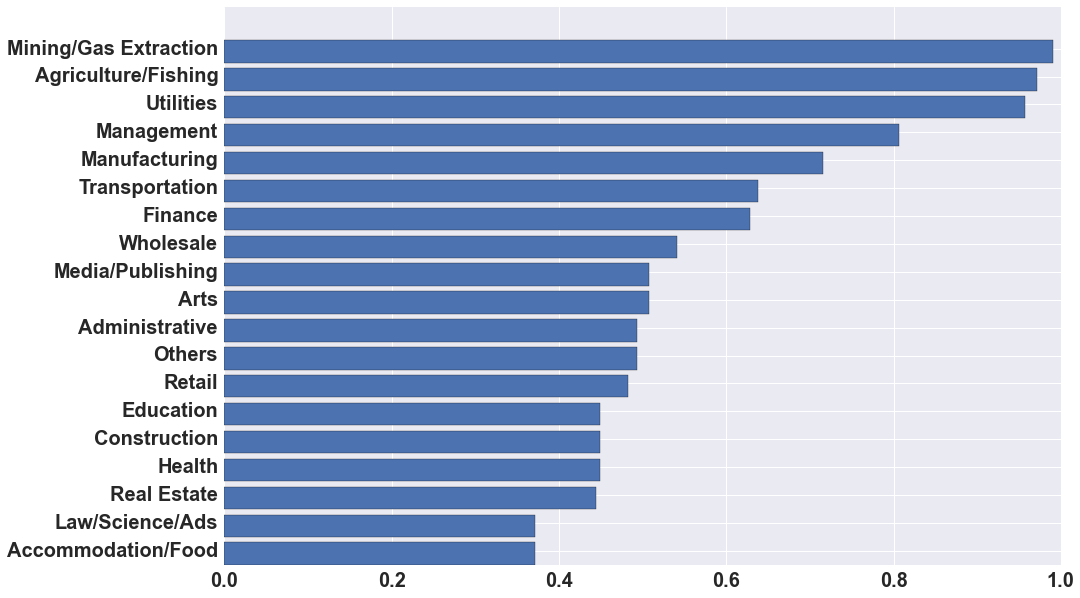

In [164]:
fig = plt.figure(figsize=(15,10))
# sort importances

# indices = np.arange(len(scores)-1)
indices = np.argsort(scores[:-1])
# plot as bar chart
# plt.barh(np.arange(len(business_codes)-1), scores[:-1])
# plt.yticks(np.arange(len(business_codes)-1) + 0.5, np.array(business_names)[:-1])

plt.barh(np.arange(len(business_codes)-1), np.array(scores)[indices])
plt.yticks(np.arange(len(business_codes)-1) + 0.5, np.array(business_names)[indices])

# plt.barh(np.arange(len(feature_names)), clf.feature_importances_[indices])
# plt.yticks(np.arange(len(feature_names)) + 0.5, np.array(feature_names)[indices])


# _ = plt.xlabel('Relative importance')
# plt.title([title + ':' + str(score)],fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
sns.set_context("poster")
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
# plt.axvline(0.44, color='red', linewidth=2)

(array([ 9216.,     0.,     0.,   840.,     0.,     0.,    13.,     0.,
            0.,   251.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

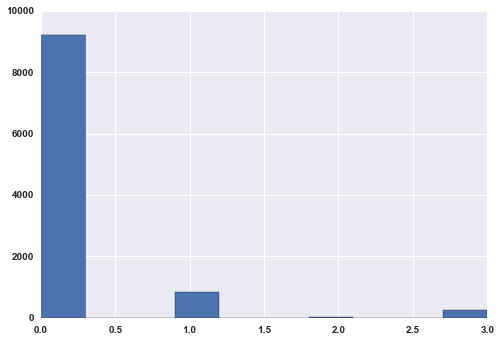

In [45]:
plt.hist(y_2013_merged)

## 4.1 Random forest feature selection
0. Start with a single business type
1. Run random forest with all features.
2. Compute accuracy.
3. Compute feature importance.
4. Pick top 5, and run it again.
5. Compute accuracy.
6. Compare.
7. Loop over the rest of the features and repeat 2-3.
8. Plot the graph.

In [315]:
print business_codes
print business_names

[11, 21, 22, 23, 30, 42, 45, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 99]
['Agriculture/Fishing', 'Mining/Gas Extraction', 'Utilities', 'Construction', 'Manufacturing', 'Wholesale', 'Retail', 'Transportation', 'Media/Publishing', 'Finance', 'Real Estate', 'Law/Science/Ads', 'Management', 'Administrative', 'Education', 'Health', 'Arts', 'Accommodation/Food', 'Others', 'Public']


In [316]:
np.array(business_codes)[np.array(business_names)=='Finance']

array([52])

In [319]:
# def rf_eval_feat(feature_names,clf,title,score):
#     fig = plt.figure(figsize=(15,10))
#     # sort importances
#     indices = np.argsort(clf.feature_importances_)
#     # plot as bar chart
#     plt.barh(np.arange(len(feature_names)), clf.feature_importances_[indices])
#     plt.yticks(np.arange(len(feature_names)) + 0.5, np.array(feature_names)[indices])
#     _ = plt.xlabel('Relative importance')
#     plt.title([title + ':' + str(score)],fontsize=20)
#     plt.tick_params(axis='x', labelsize=20)
#     plt.tick_params(axis='y', labelsize=20)
#     return indices

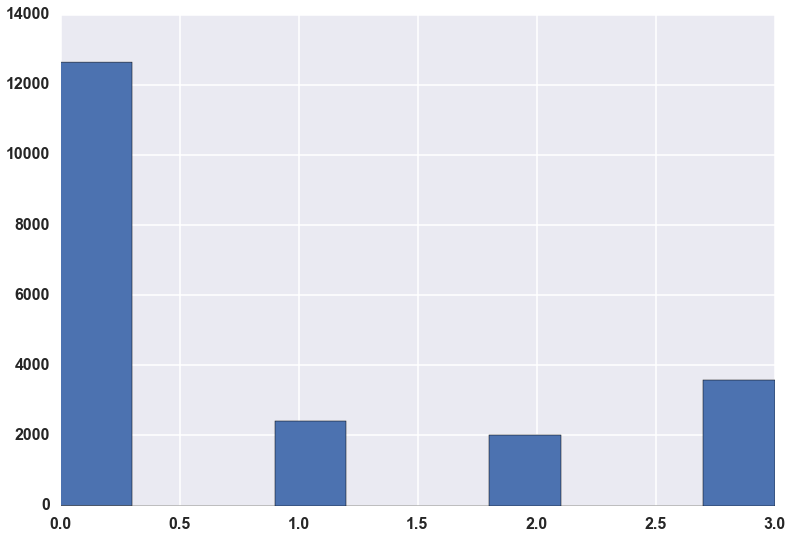

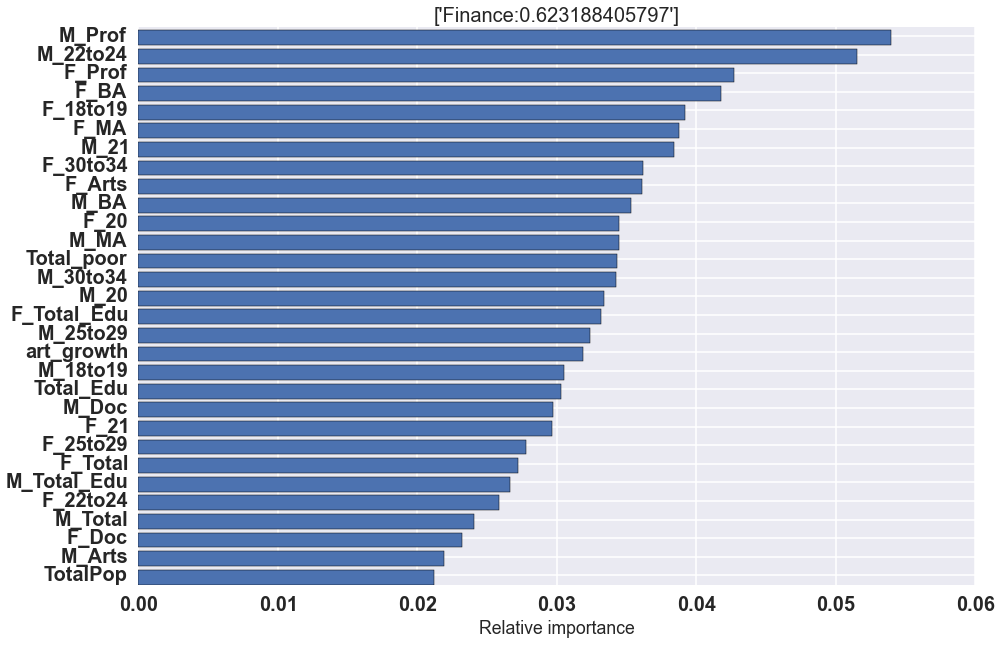

In [32]:
temp = assign_biz_multiclass2(0.05)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))

# 0. Start with a single business type
biz_code = 52
biz_name = 'Finance'

# 1. Run random forest with all features.
clf = RandomForestClassifier(max_depth=5, n_estimators=100)
df_2011 = gb.get_group((2011,biz_code))
df_2012 = gb.get_group((2012,biz_code))
test_size = 0.4
X = df_2011.ix[:,2:32]
y = df_2012.ix[:,-1]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    
clf.fit(X_train, y_train)

# 2. Compute accuracy.
score = clf.score(X_test, y_test)

# 3. Compute feature importance.
feature_names = df_2011.columns[2:32]
indices = rf_eval_feat(feature_names,clf,biz_name,score)

In [508]:
np.arange(len(feature_names))[feature_names[indices]=='art_growth']

array([12])

In [343]:
# so these are bottom 5
feature_names[indices[:5]]

Index([u'F_21', u'F_25to29', u'Total_poor', u'F_20', u'M_Total'], dtype='object')

In [342]:
# 4. Pick top 5, and run it again.
"""
    indices: ascending order
    ex. indices[:5]: the first 5 lowest
    so, top n features by index: indices[-n:]
"""
print indices
print indices[-5:]

[11 13 26 10  1 25 17 27 22 12 23 24 29  2  3 16 20 15  4  0  6  8 28 21  7
 14  5  9 18 19]
[14  5  9 18 19]


In [348]:
np.shape(X[:,indices[-5:]])

(516, 5)

In [354]:
X[:,indices[-5:]]

array([[-1.02620348,  0.04449427,  0.31283269, -0.88605526,  0.99599327],
       [-0.03132315, -0.20506342, -0.24513779, -0.11983613, -0.64037697],
       [ 0.41465327, -0.3626508 ,  0.12289347, -4.157093  , -0.2053299 ],
       ..., 
       [-0.19118855, -0.01087995, -0.36435163, -0.18858199, -0.2053299 ],
       [-0.19118855, -0.76601164,  0.21892195, -0.18858199,  5.4898318 ],
       [-0.19118855, -0.15287919, -0.06957186, -0.18858199, -1.24712777]])

In [367]:
# 5. Compute accuracy and compare (top 5)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X[:,indices[-5:]], y, test_size=test_size, random_state=0)    
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.618357487923


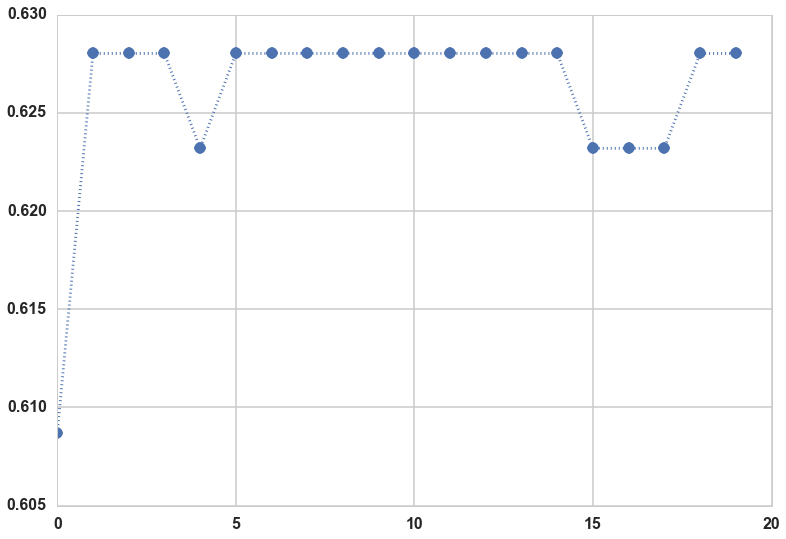

In [382]:
# 6: compare: loop over first n indices, and see how accuracy changes

indices = np.argsort(clf.feature_importances_)
scores = []
for i in range(1,21):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X[:,indices[-i:]], y, test_size=test_size, random_state=0)    
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
plt.plot(scores,':o')
plt.show()
# 7. Loop over the rest of the features and repeat 2-3.
# 8. Plot the graph.

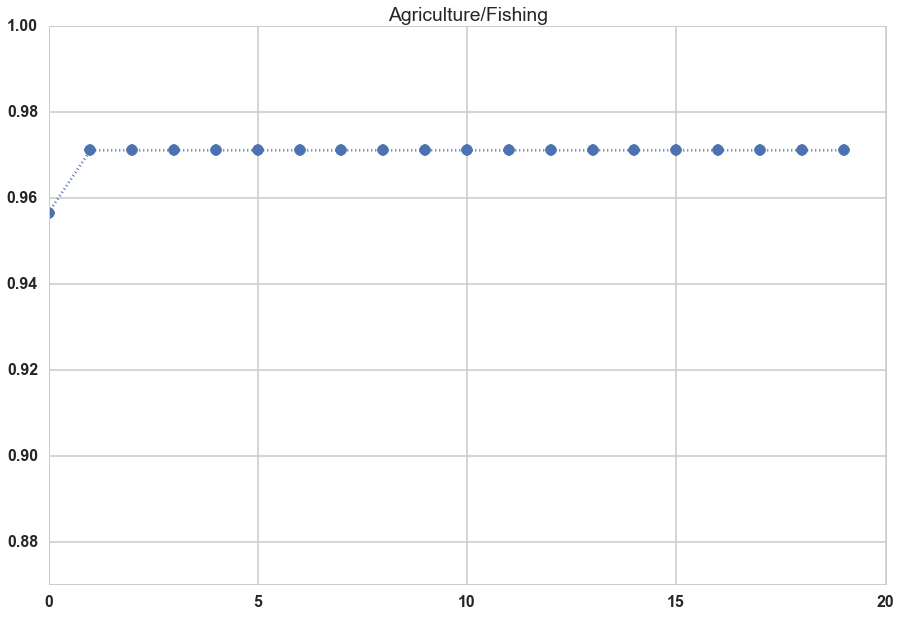

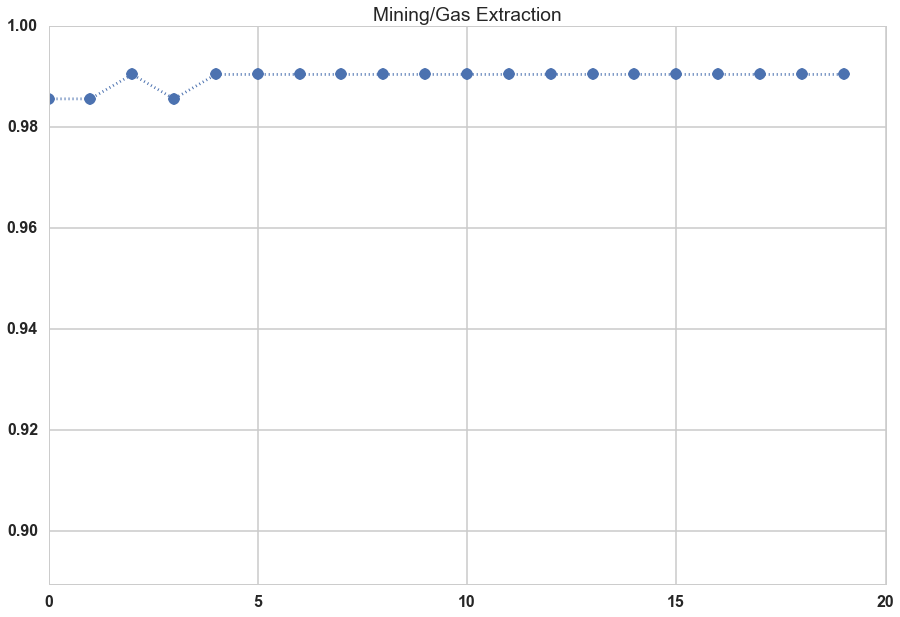

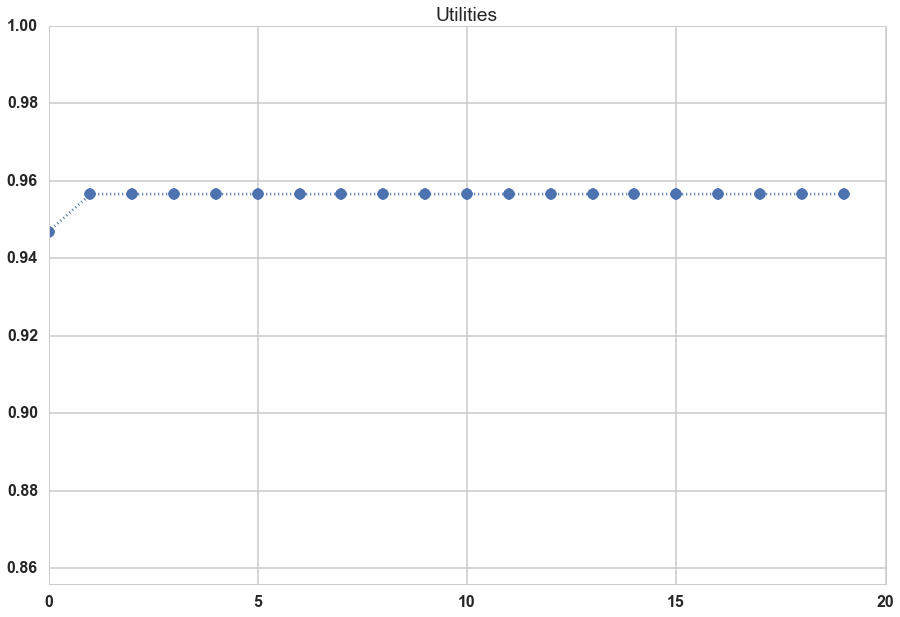

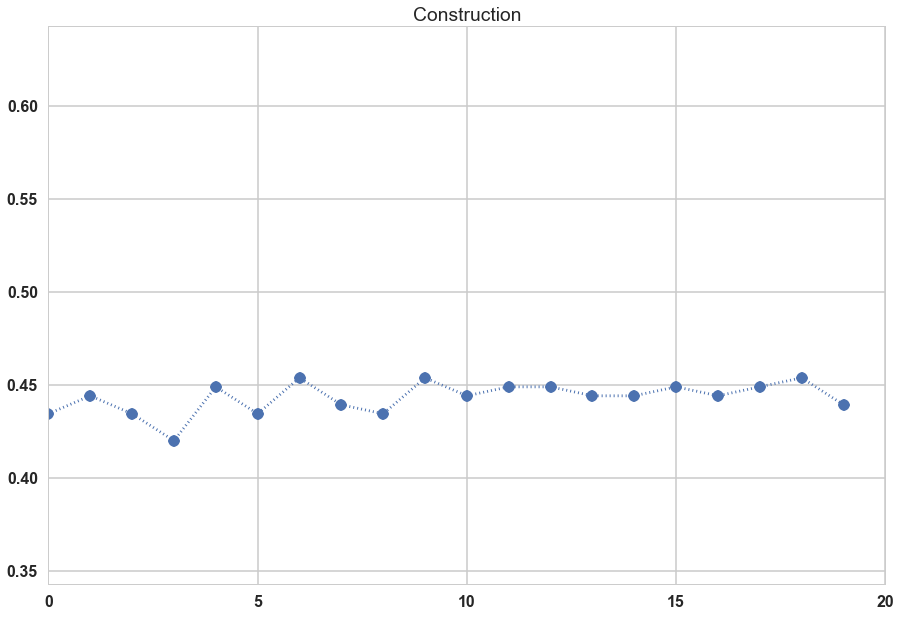

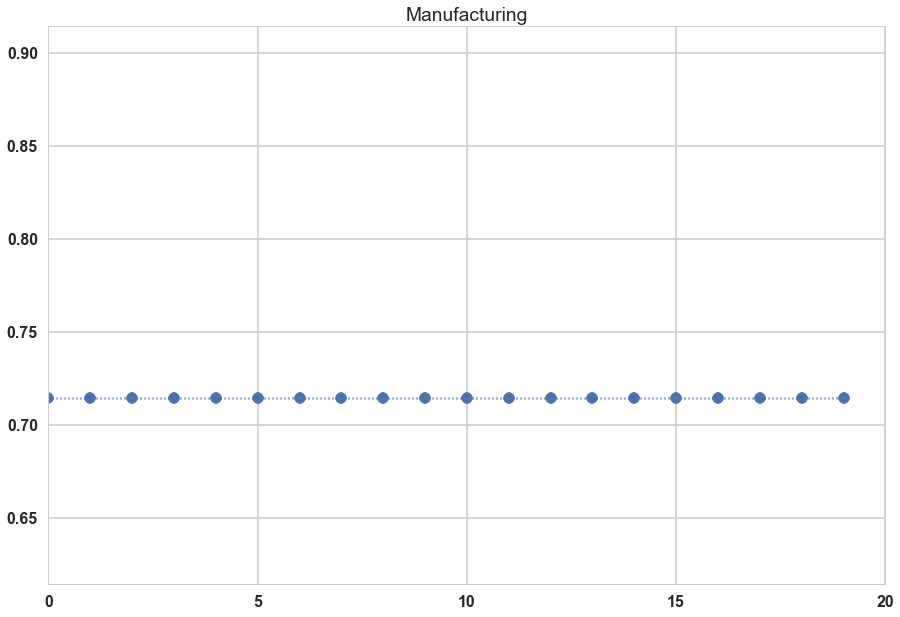

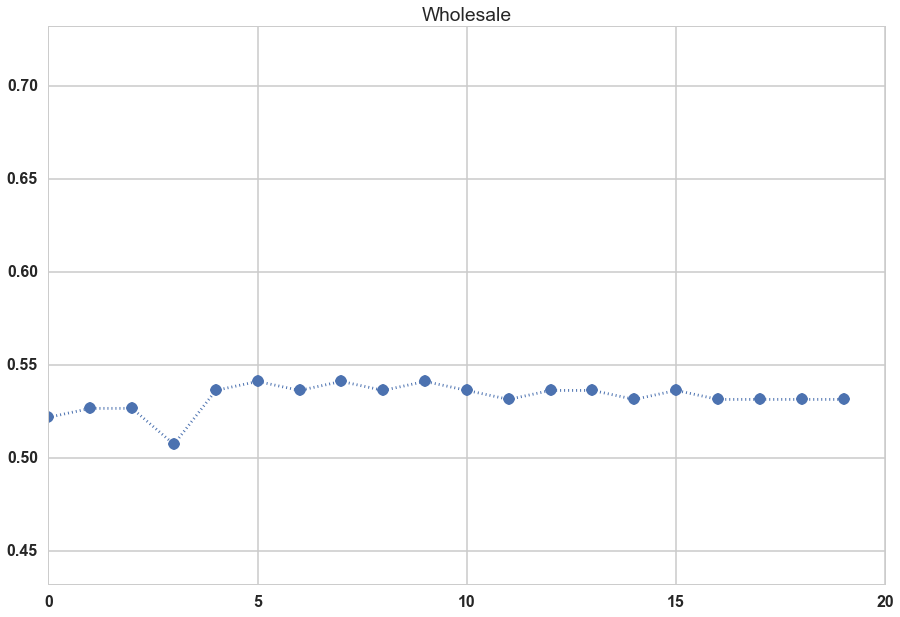

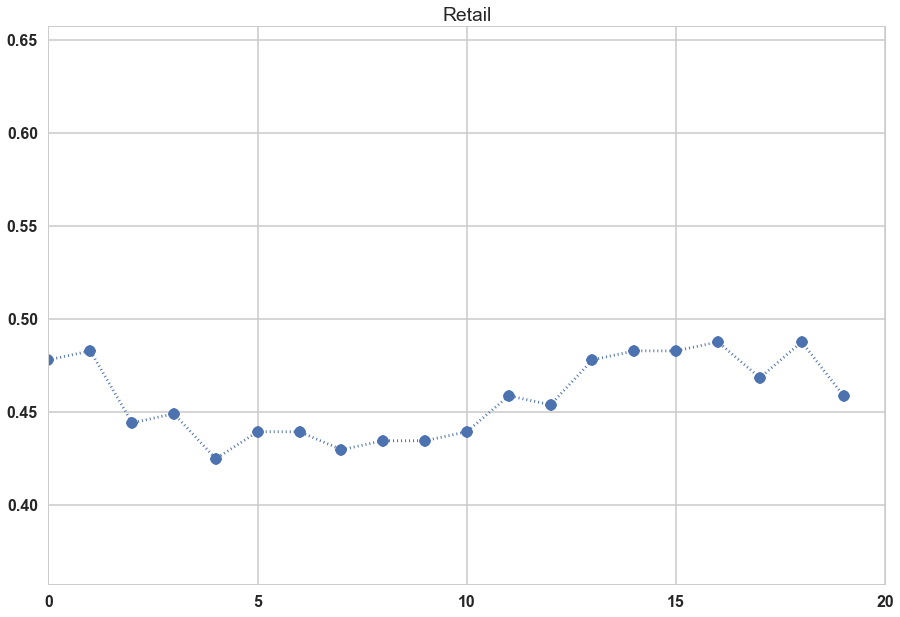

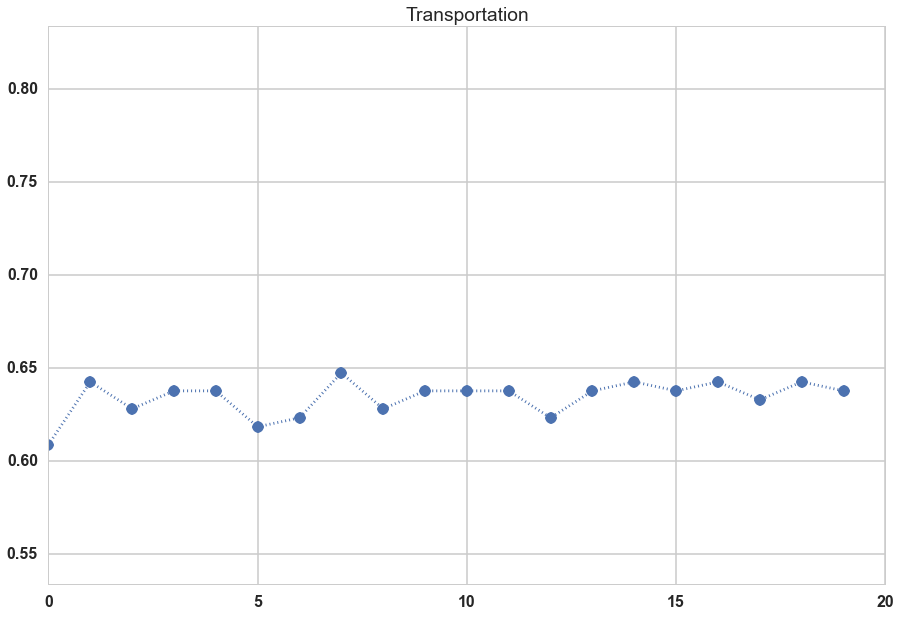

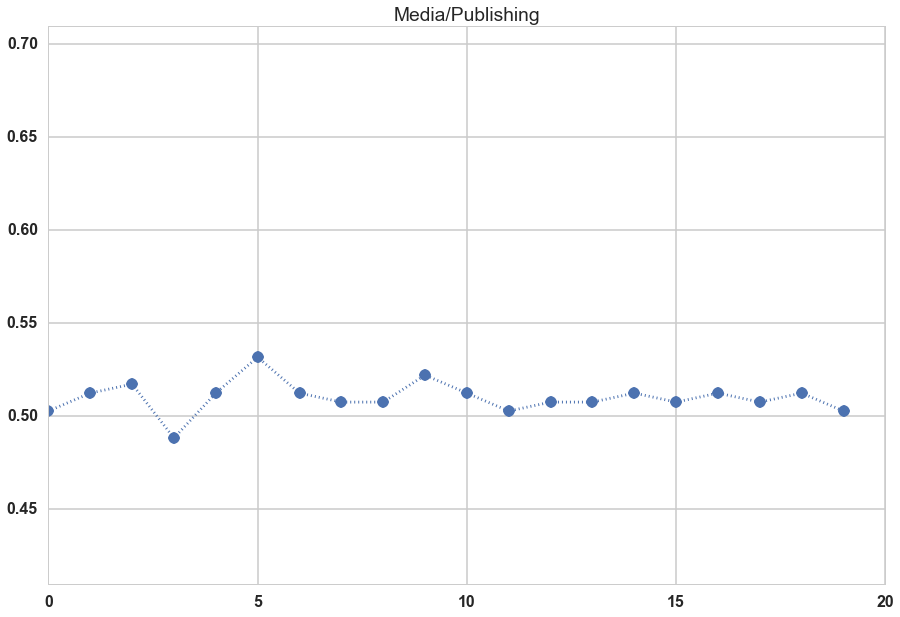

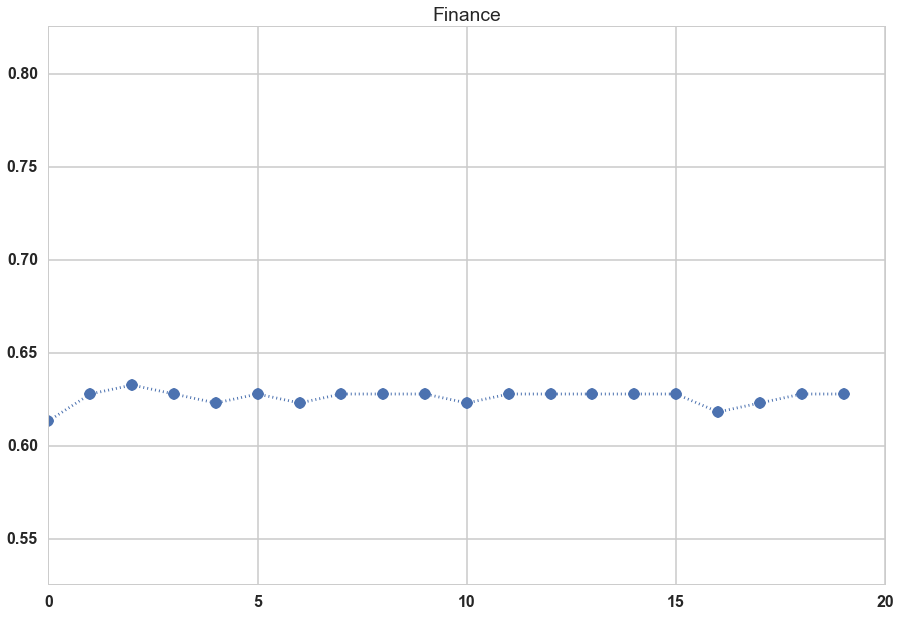

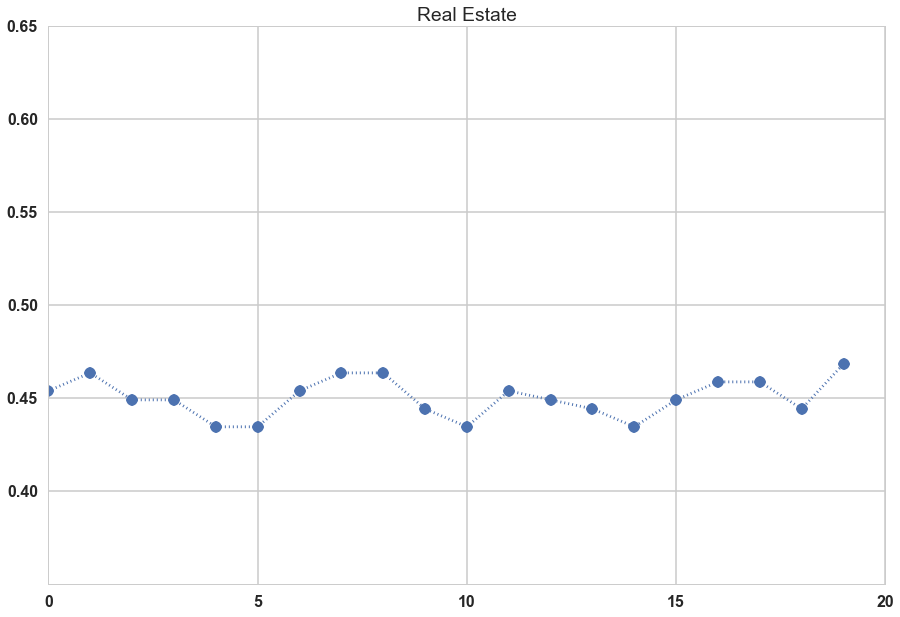

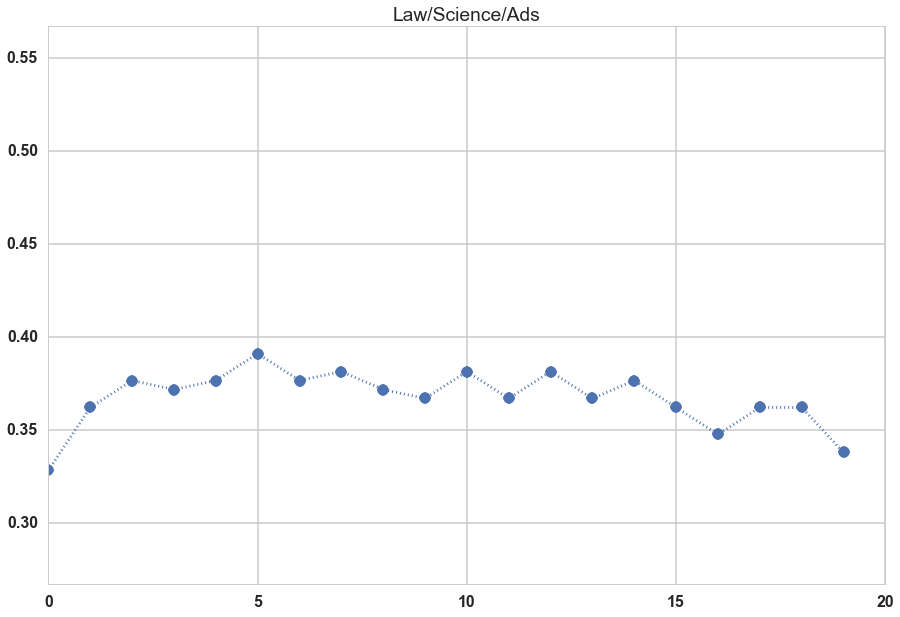

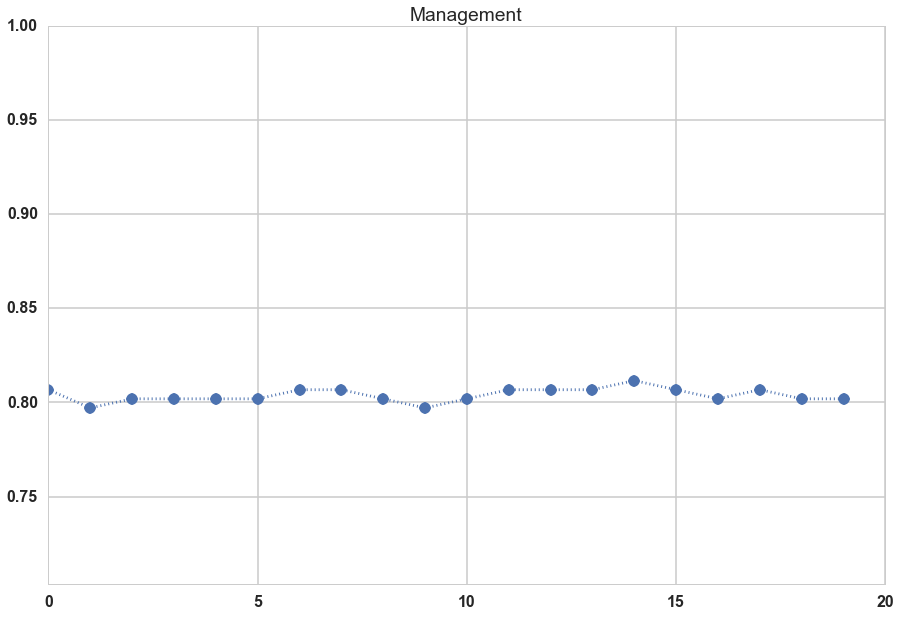

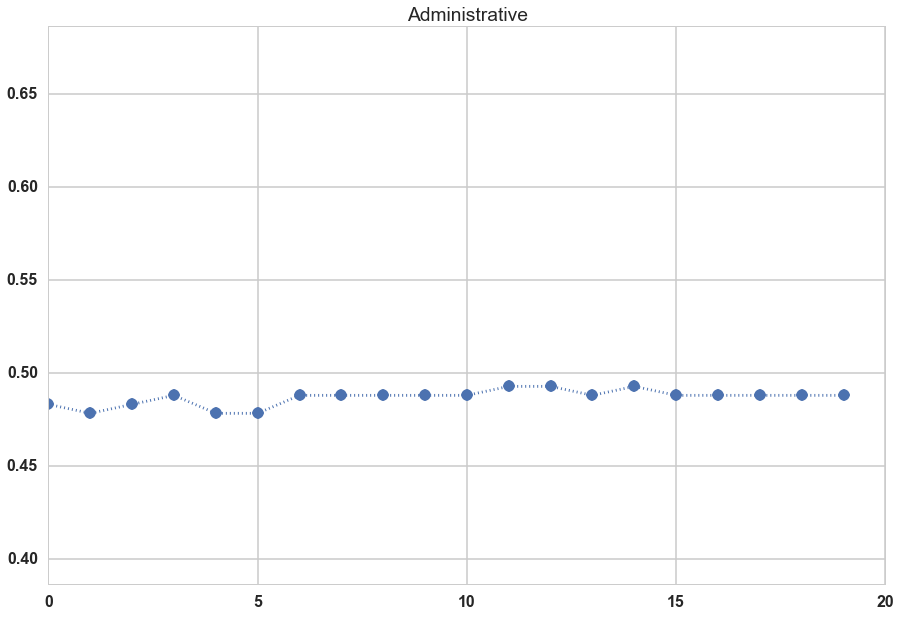

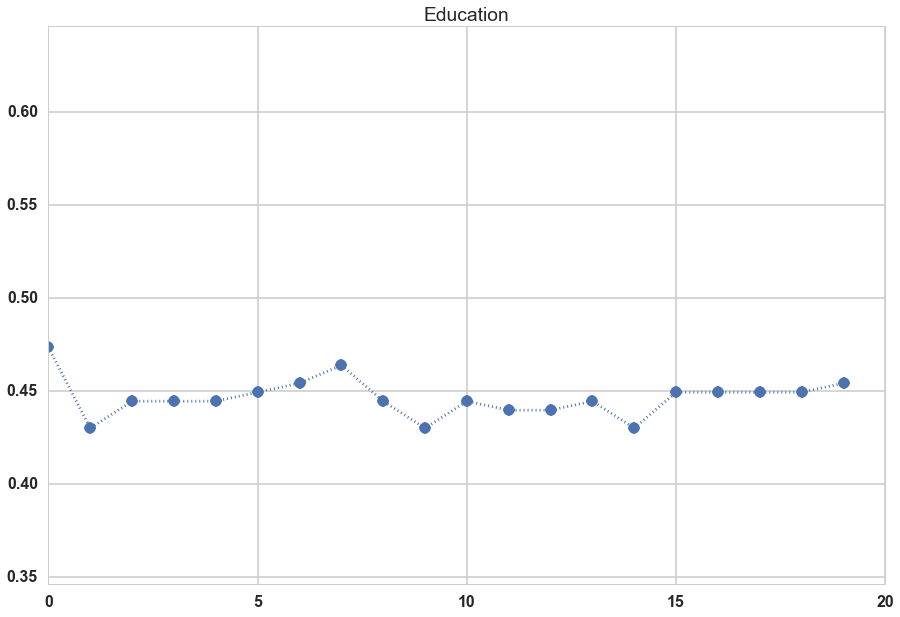

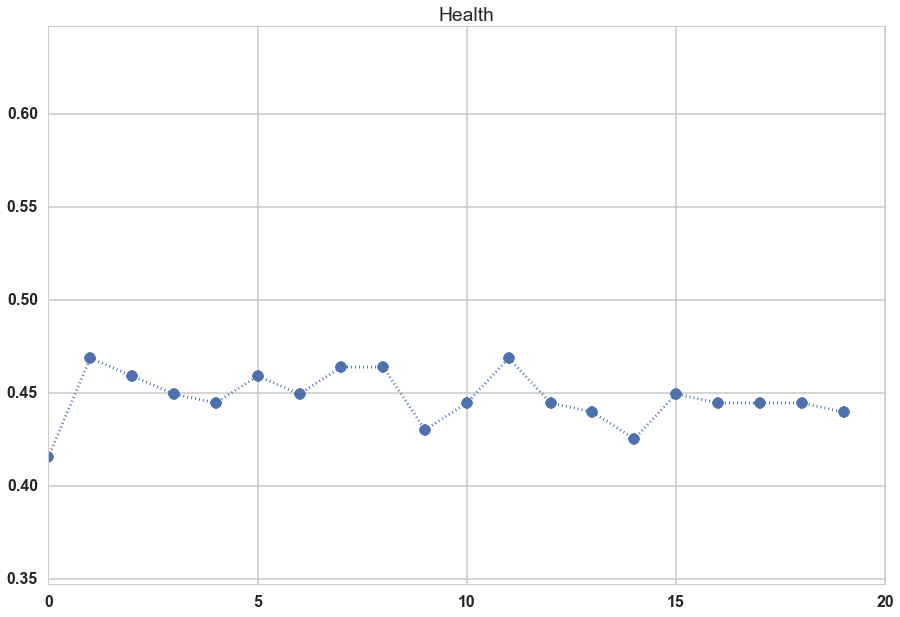

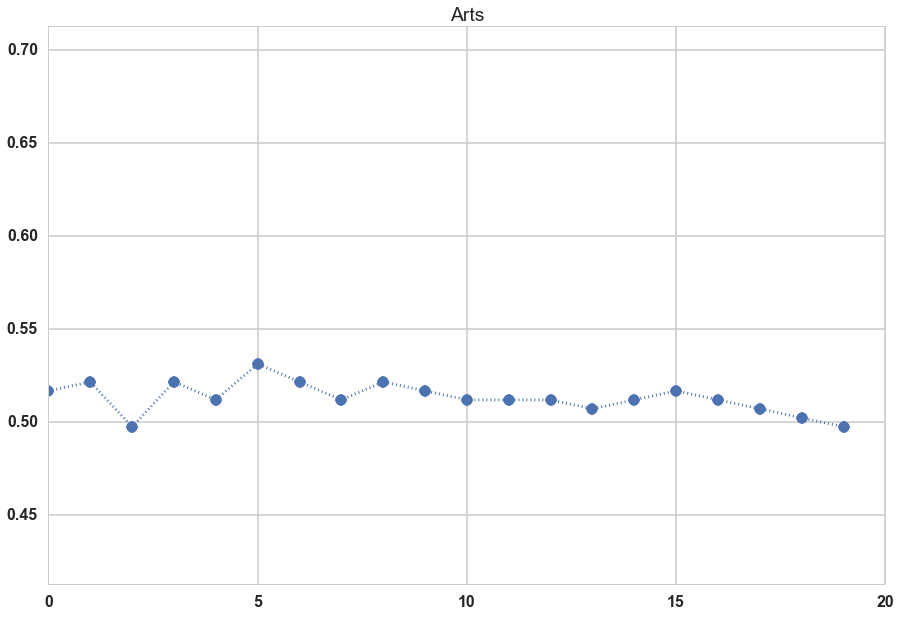

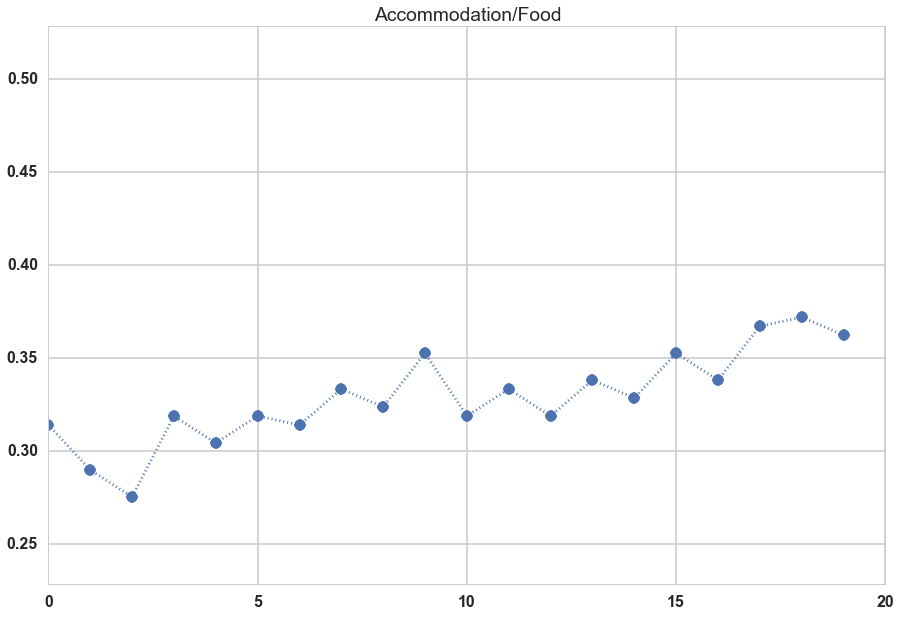

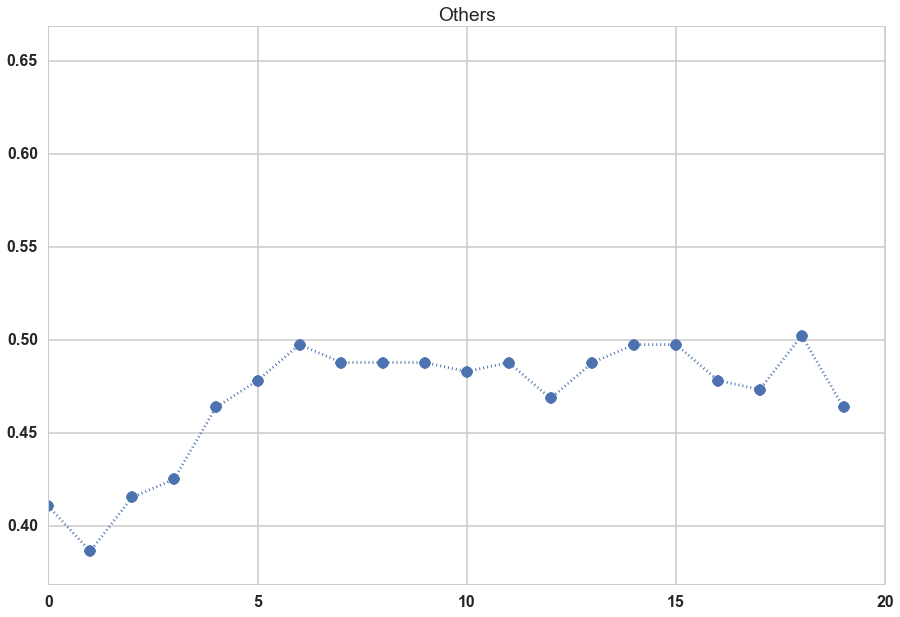

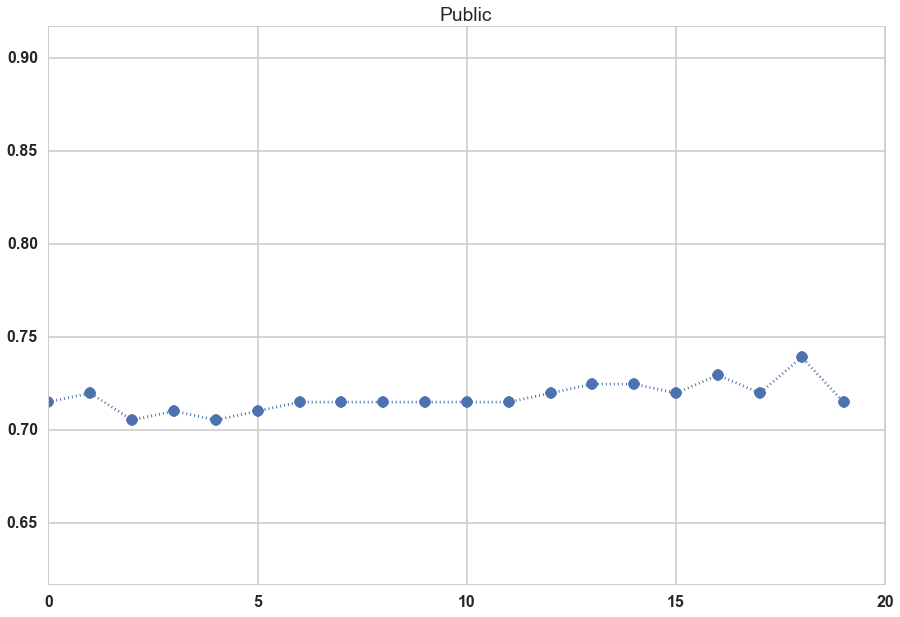

In [395]:
# 7. Loop over the rest of the features and repeat steps 2 and 3.

scores_all = []
df_feat_import = pd.DataFrame()
for biz_code,biz_name in zip(business_codes,business_names):
    df_2011 = gb.get_group((2011,biz_code))
    df_2012 = gb.get_group((2012,biz_code))
    test_size = 0.4

    X = df_2011.ix[:,2:32]
    y = df_2012.ix[:,-1]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

    clf.fit(X_train, y_train)
    score_all = clf.score(X_test, y_test)
    scores_all.append(score_all)

    scores = []
    for i in range(1,21):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X[:,indices[-i:]], y, test_size=test_size, random_state=0)    
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    df_feat_import[biz_name]=scores
    fig = plt.figure(figsize=(15,10))
    plt.plot(scores,':o')
    plt.title(biz_name)
    plt.ylim([np.average(scores)-.1, min(np.average(scores)+.2,1.0)])

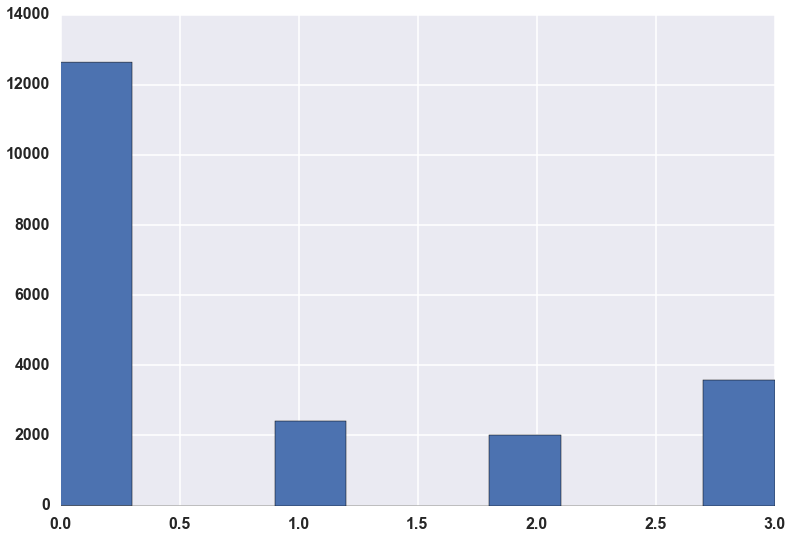

In [40]:
# 8. The results depend on train/test datasets. Repeat this 10 times to get standard errors.
temp = assign_biz_multiclass2(0.05)
df_multinom = df_all
df_multinom['biz_index']=pd.DataFrame(temp)
gb = df_multinom.groupby(('year','business_code'))

n_runs = 10
df_feat_import_n = pd.DataFrame()
for n in range(n_runs):
    scores_all = []
    df_feat_import = pd.DataFrame()
    for biz_code,biz_name in zip(business_codes,business_names):
        df_2011 = gb.get_group((2011,biz_code))
        df_2012 = gb.get_group((2012,biz_code))
        test_size = 0.4

        X = df_2011.ix[:,2:32]
        y = df_2012.ix[:,-1]
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=0)    

        clf.fit(X_train, y_train)
        score_all = clf.score(X_test, y_test)
        scores_all.append(score_all)

        scores = []
        for i in range(1,21):
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X[:,indices[-i:]], y, test_size=test_size, random_state=0)    
            clf.fit(X_train, y_train)
            scores.append(clf.score(X_test, y_test))
        df_feat_import['try']=range(1,21)
        df_feat_import['num_feat']=i
        df_feat_import[biz_name]=scores
    df_feat_import_n = pd.concat([df_feat_import_n, df_feat_import],ignore_index=True)

# 5. City level data visualization

In [99]:
gb_year = df_all.groupby('year',as_index=False)
# df_2011 = gb_year.get_group(2011)
# df_2012 = gb_year.get_group(2012)
# gb_11 = df_2011.groupby(('city','business_code'),as_index=False)
# gb_12 = df_2012.groupby(('city','business_code'),as_index=False)
cities = df_all.city.unique()

In [47]:
def plot2D_city_biz(gb_year,year,business_names,cities):
    
    # select a year
    df = gb_year.get_group(year)
    # groupby
    gb = df.groupby(('city','business_code'),as_index=False)
    # comput the average
    df_ = gb.agg(np.average)
    # simplify
    df_ = df_[['city','business_code','year','biz_growth']]
    city_biz = []
    for city in cities:
        temp = df_[df_['city']==city]
        city_biz.append(list(temp.biz_growth.values))
    city_biz_array = np.array(city_biz)
    # plot
    fig = plt.figure(figsize=(15,5))
    sns.set()
    sns.set_context("poster")
    ax = sns.heatmap(city_biz_array, xticklabels=business_names, yticklabels=cities, vmin=-.4, vmax=.4)

In [ ]:
plot2D_city_biz(gb_year,2011,business_names,cities)

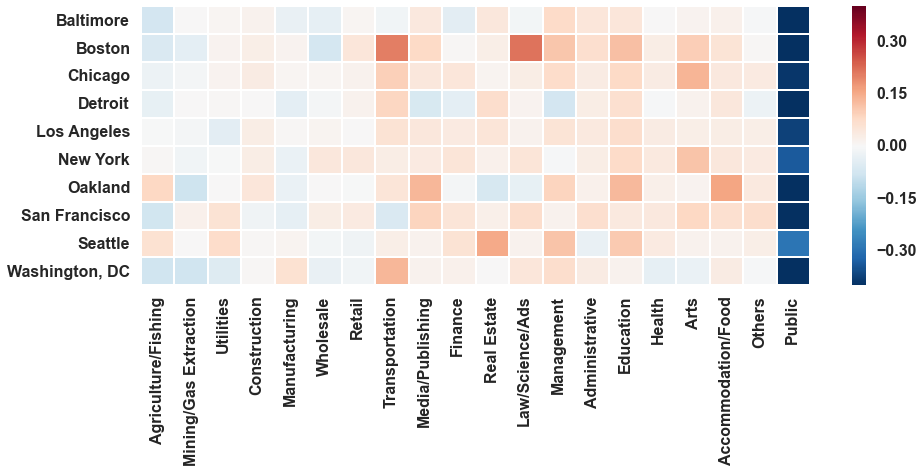

In [53]:
plot2D_city_biz(gb_year,2011,business_names,cities)

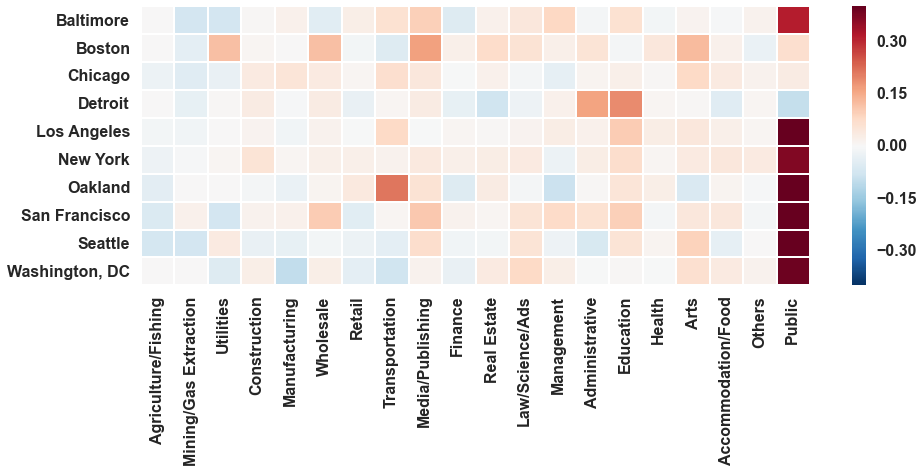

In [54]:
plot2D_city_biz(gb_year,2012,business_names,cities)

In [100]:
year = 2011
df = gb_year.get_group(year)
# groupby
gb = df.groupby('city',as_index=False)
# comput the average
df_ = gb.agg(np.average)
# df_ = gb.get_group('Chicago')

df_.ix[:,3:33].head()
# df_.head()

TotalPop   M_Total  M_18to19      M_20      M_21  M_22to24  M_25to29  \
0  0.001748  0.001324  0.020618  0.005246  0.028095  0.031644  0.025178   
1  0.032049  0.030430  0.105785  0.066143  0.158681 -0.055205  0.031907   
2  0.019909  0.020937  0.054781  0.091120  0.081509  0.059768  0.048724   
3 -0.016089 -0.010526  0.068138  0.138538  0.528066  0.328112  0.015188   
4  0.017494  0.016594  0.116341  0.069482  0.066660  0.090491  0.036934   

   M_30to34   F_Total  F_18to19     ...         M_Doc  F_Total_Edu      F_BA  \
0  0.026844  0.003100  0.062382     ...      0.211309     0.005263  0.019255   
1  0.075017  0.037712 -0.118574     ...      0.368897     0.048242  0.063376   
2  0.058677  0.020011 -0.020444     ...      0.066947     0.021335  0.044961   
3 -0.007962 -0.020730  0.029677     ...      0.207683    -0.017705  0.007216   
4  0.072921  0.019226  0.059746     ...      0.110857     0.025804  0.060023   

       F_MA    F_Prof     F_Doc  Total_poor    M_Arts    F_Arts  art_growth  
0  0.016986  0.074994  0.104844    0.051404  0.274507 -0.013465   -0.197151  
1  0.038888  0.190450  0.219049    0.024658  0.309405  0.086541    0.876392  
2  0.049016  0.108378  0.040022    0.079600  0.006944  0.121396    0.883500  
3  0.011462  0.071001  0.361591    0.033603  0.132747  0.187996   -0.120004  
4  0.093117  0.189645  0.036699    0.060130  0.066459  0.062769    0.566287  

[5 rows x 30 columns]

In [49]:
def plot2D_city_demo(gb_year,year,cities):
    
    df = gb_year.get_group(year)
    # groupby
    gb = df.groupby('city',as_index=False)
    # comput the average
    df_ = gb.agg(np.average)
    df_ = df_.ix[:,3:33]
    
    city_demo = []
    for i in range(len(cities)):
        temp = df_.ix[i,:]
        city_demo.append(list(temp.values))
    city_demo_array = np.array(city_demo)
    # plot
    fig = plt.figure(figsize=(19,5))
    sns.set()
    sns.set_context("poster")
    ax = sns.heatmap(city_demo_array, xticklabels=df_.columns, yticklabels=cities, vmin=-1,vmax=1)

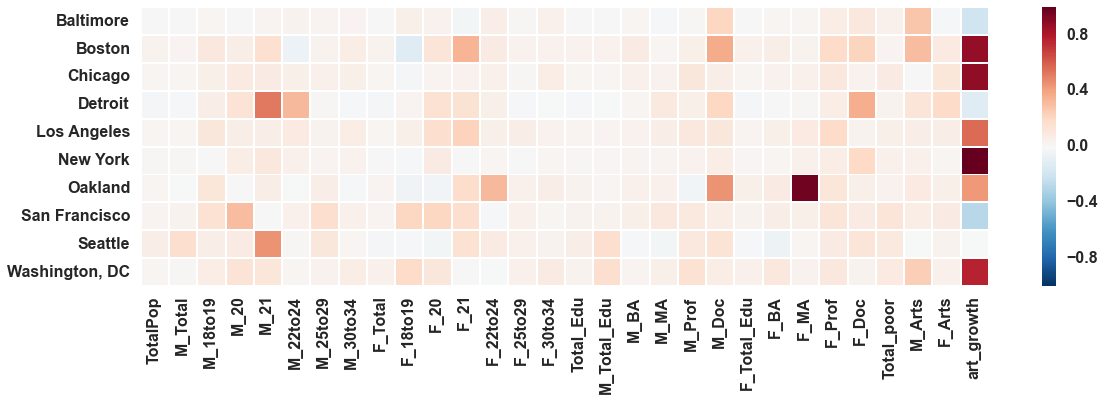

In [57]:
plot2D_city_demo(gb_year,2011,cities)

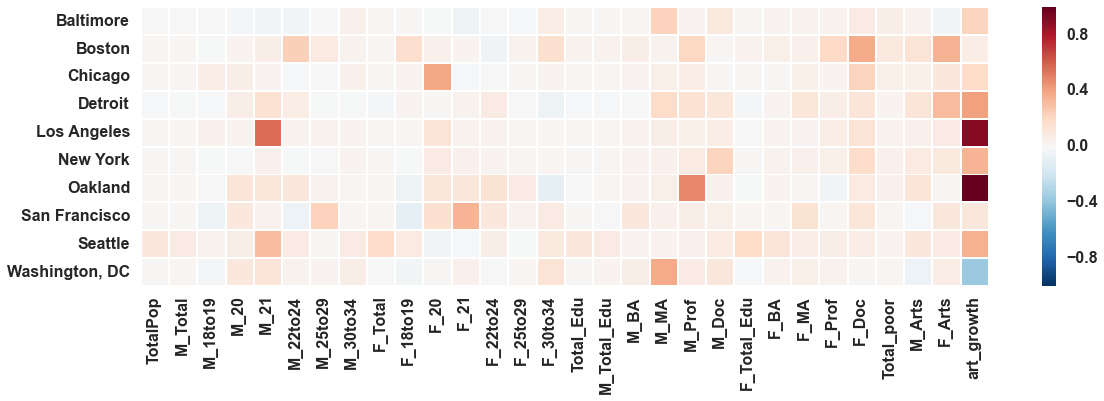

In [58]:
plot2D_city_demo(gb_year,2012,cities)

In [101]:
df_all.biz_index.unique()

array([0, 2, 1, 3])

In [102]:
df = df_all[['city', 'zip_code', 'business_code', 'biz_growth', 'biz_index','year']]

1. Dropdown menu of all cities
    - Biz growth data is stored by city
    - City is queried
    - Growth rate data is called.
        - SQL
            - This is 2012(-2013) data.
            - Columns: city, zip code, business code, growth rate, growth index
            - SELECT ZIP_CODE, GROWTH_RATE FROM TABLE;
                WHERE CITY = 'CHICAGO'
        - Python
            - Folium: create map
            - Folium: bind data
            - Create maps
                1. Map on average growth
                2. Map by category
2. User pick a city, then a map appears
3. Heatmap with overall growth index is shown first
4. There are buttons or another dropbown menu for users to choose a certain business category
    - User clicks the button
    - Then map changes
5. Based on the business category, map changes.

# Bind data to folium

In [103]:
zip_codes = df.zip_code.unique()

In [341]:
# filter geojson file based on zip_codes
geo_file = 'zip_cities.json'
import json
with open(geo_file) as f:
    data = json.load(f)

In [349]:
df_feat = pd.DataFrame(data['features'])
temp = pd.DataFrame()
for i in range(len(data['features'])):
    if int(data['features'][i]['properties']['ZCTA5CE10']) in zip_codes:
        temp = pd.concat([temp,df_feat.iloc[[i]]],ignore_index=True)
dict_temp = temp.to_dict(orient='records')
data['features'] = dict_temp
with open('zip_cities_final.json', 'w') as f:
    json.dump(data, f)

In [351]:
import folium
m = folium.Map(location=[37.769959, -122.448679], zoom_start=9)
m.geo_json(geo_path='zip_cities_final.json')
m.create_map('test_.html')

In [356]:
data['features'][0]['properties']

{u'AFFGEOID10': u'8600000US94132',
 u'ALAND10': 8054467,
 u'AWATER10': 1299131,
 u'GEOID10': u'94132',
 u'ZCTA5CE10': u'94132'}

In [104]:
# add zero to 4 digit zip codes
temp = (df.zip_code.apply(str))
temp.unique()
zips = []
for zip_code in temp:
    if len(zip_code)==4:
        zip_code = '0' + zip_code
    zips.append(zip_code)
# attach it to the original table
df['zips'] = zips

/Users/Hongsup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
df.head()

city  zip_code  business_code  biz_growth  biz_index  year   zips
0  Baltimore     21201             11    0.000000          0  2011  21201
1  Baltimore     21201             21    0.000000          0  2011  21201
2  Baltimore     21201             22    0.000000          0  2011  21201
3  Baltimore     21201             23    0.052632          2  2011  21201
4  Baltimore     21201             30   -0.300000          0  2011  21201

In [106]:
print business_codes

[11, 21, 22, 23, 30, 42, 45, 49, 51, 52, 53, 54, 55, 56, 61, 62, 71, 72, 81, 99]


(array([ 9282.,     0.,     0.,   776.,     0.,     0.,    32.,     0.,
            0.,   230.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

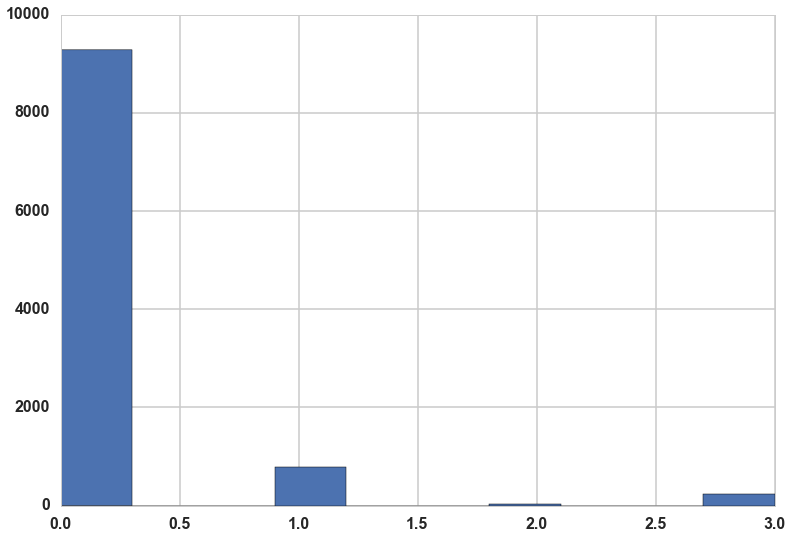

In [107]:
plt.hist(y_2013_merged)

In [118]:
# test 2012 data
import folium
geo_path = 'zip_cities_final.json'

df_2012 = df[df.year==2012]
# df_2012['predict']=y_2013_merged
gb = df_2012.groupby('business_code')

# for biz_code in business_codes:
biz_code = 11
data = gb.get_group(biz_code)

# LOOP DOES NOT WORK! IT OVERWRITES IT
m = folium.Map(location=[37.769959, -122.448679], zoom_start=9)
m.geo_json(geo_path=geo_path, 
             data=data,
             columns=['zips', 'biz_index'],
             threshold_scale=range(0,4),
             key_on='feature.properties.ZCTA5CE10',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Business Growth Index')
m.create_map('test_bind_' + str(biz_code) + '.html')

In [132]:
# Bind data to Folium: this is for prediction data
import folium

df_2012 = df[df.year==2012]
df_2012['predict']=y_2013_merged
gb = df_2012.groupby(('year','business_code'))

# biz_code=11
# for biz_code in business_codes:

def create_map(biz_code,gb):
    geo_path = 'zip_cities_final.json'
    
    data = gb.get_group((2012,biz_code))
    m = folium.Map(location=[37.769959, -122.448679], zoom_start=9)
    m.geo_json(geo_path=geo_path, 
                data_out = 'data' + str(biz_code) + '.json',
                data=data,
                columns=['zips', 'predict'],
                threshold_scale=range(0,4),
                key_on='feature.properties.ZCTA5CE10',
                fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                legend_name='Business Growth Index')
    m.create_map('biz_map_' + str(biz_code) + '.html')

/Users/Hongsup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [133]:
for i in range(len(business_codes)-1):
    create_map(business_codes[i],gb)

### City location coordinates

In [149]:
cities

array(['Baltimore', 'Boston', 'Chicago', 'Detroit', 'Los Angeles',
       'New York', 'Oakland', 'San Francisco', 'Seattle', 'Washington, DC'], dtype=object)

In [152]:
import requests
# Google Maps API
GOOGLE_KEY = ''

# Convert zip codes to coordinates
city_names = ['Baltimore,+MD', 'Boston,+MA', 'Chicago,+IL', 'Detroit,+MI', 'Los+Angeles,+CA',
       'New+York,+NY', 'Oakland,+CA', 'San+Francisco,+CA', 'Seattle,+WA', 'Washington,+DC']
lats2 = []
lngs2 = []
for city_name in city_names:
    query_url = 'https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s' % (city_name, GOOGLE_KEY)
    r = requests.get(query_url)    
    temp = r.json()
    if len(temp['results'])==0:
        lat = 'none'
        lng = 'none'    
    else:
        lat = temp['results'][0]['geometry']['location']['lat']
        lng = temp['results'][0]['geometry']['location']['lng']
    lats2.append(lat)
    lngs2.append(lng)

In [157]:
city_coordinates = zip(lats2,lngs2)
city_coordinates

[(39.2903848, -76.6121893),
 (42.3600825, -71.0588801),
 (41.8781136, -87.6297982),
 (42.331427, -83.0457538),
 (34.0522342, -118.2436849),
 (40.7127837, -74.0059413),
 (37.8043637, -122.2711137),
 (37.7749295, -122.4194155),
 (47.6062095, -122.3320708),
 (38.9071923, -77.0368707)]

# *Linear Regression
## (census + art) vs. biz growth as a vector

In [195]:
# X: 2011-2012 data, Y: 2012-2013 data
# train and test decided by zip code
gb = df_all.groupby('year')
df_2011 = gb.get_group(2011)
df_2012 = gb.get_group(2012)
from sklearn import cross_validation
X_train_df, X_test_df, y_train_df, y_test_df = cross_validation.train_test_split(df_2011, df_2012, test_size=0.2, random_state=0)

In [196]:
from sklearn import linear_model
# choose features
X_train = X_train_df.ix[:,2:32]
X_test = X_test_df.ix[:,2:32]
y_train = y_train_df.ix[:,-1]
y_test = y_test_df.ix[:,-1]
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.013475862019180718

## (census+art) vs. average biz growth across all categories

In [197]:
gb = df_all.groupby(('year','zip_code'),as_index=False)
# gb = df2.groupby(('zip_code','year','business_code'),as_index=False)
gb_avr = gb.agg(np.average)
gb_avr.head()

year  zip_code  TotalPop   M_Total  M_18to19      M_20      M_21  M_22to24  \
0  2011      2108  1.059138  1.064752  1.638889  1.500000  2.000000  0.694915   
1  2011      2109  1.058140  1.160180  1.000000  0.923077  1.066667  0.700000   
2  2011      2110  0.936948  0.896216  1.250000  0.000000  0.000000  1.370370   
3  2011      2111  1.088778  1.103334  0.946429  0.936842  1.300000  0.869458   
4  2011      2113  1.075059  1.111183  0.000000  0.936441  0.829787  1.051635   

   M_25to29  M_30to34     ...          F_BA      F_MA    F_Prof     F_Doc  \
0  1.276265  1.013274     ...      1.090663  1.111446  1.194969  1.304348   
1  0.988304  1.449761     ...      0.924370  1.116667  0.968354  0.833333   
2  1.048780  0.857143     ...      1.058824  0.646552  2.189189  1.023810   
3  0.970721  1.317797     ...      1.090211  1.162011  1.150259  1.339286   
4  1.054224  1.159664     ...      1.250264  1.054825  0.981132  1.130435   

   Total_poor    M_Arts    F_Arts  art_growth  business_code  biz_growth  
0    0.967213  4.625000  0.768116    2.097561           50.5    0.912149  
1    1.039474  0.000000  1.243243    2.190722           50.5    1.178312  
2    0.819209  2.000000  0.000000    1.206266           50.5    0.908773  
3    0.936445  2.750000  0.714286    1.210425           50.5    1.032701  
4    1.008277  1.407407  0.810458    2.012000           50.5    0.683889  

[5 rows x 34 columns]

In [198]:
gb = gb_avr.groupby('year')
df_2011 = gb.get_group(2011)
df_2012 = gb.get_group(2012)
X_train_df, X_test_df, y_train_df, y_test_df = cross_validation.train_test_split(df_2011, df_2012, test_size=0.4, random_state=0)

In [199]:
X_train = X_train_df.ix[:,2:32]
X_test = X_test_df.ix[:,2:32]
y_train = y_train_df.ix[:,-1]
y_test = y_test_df.ix[:,-1]
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

-2.8262020865297672

## 1.3 (census+art) vs. biz growth by category

In [226]:
# X
df_corr2 = gb_avr.ix[:,:-2]
# Y
gb_biz = df_biz.groupby('business_code')
# biz list
biz_codes = df_biz['business_code'].unique()

In [253]:
# they are not in the same order, so let's merge and separate.
for biz_code in biz_codes:
    temp = gb_biz.get_group(biz_code)
    df_temp = pd.merge(df_corr2, temp, how='inner', on=['year', 'zip_code'])

    # split it by year
    gb_temp = df_temp.groupby('year')
    df_2011 = gb_temp.get_group(2011)
    df_2012 = gb_temp.get_group(2012)
    X_train_df, X_test_df, y_train_df, y_test_df = cross_validation.train_test_split(df_2011, df_2012, test_size=0.4, random_state=0)    
    
    X_train = X_train_df.ix[:,2:32]
    X_test = X_test_df.ix[:,2:32]
    y_train = y_train_df.ix[:,-1]
    y_test = y_test_df.ix[:,-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print 'business code:' + str(biz_code) + ' ' + str(regr.score(X_test, y_test))

business code:11 -1.58516850264
business code:21 -1.70549632154
business code:22 -0.570283676119
business code:23 -8.50125108496
business code:30 -8.63493387383
business code:42 -1.23052868325
business code:45 -20.4915116197
business code:49 -2.63808292364
business code:51 -3.89447159679
business code:52 -1.7561748792
business code:53 -2.81563074461
business code:54 -13.7551346429
business code:55 -6.39457612636
business code:56 -4.58178498096
business code:61 -4.86618160857
business code:62 -14.0123370005
business code:71 -21.3766659716
business code:72 -4.68961323121
business code:81 -13.7954539423
business code:99 -0.935851453119


## PCA(census+art) vs. biz growth as a vector

In [206]:
# We are using 2011-2012 (data to predict 2012-2013 data (business pattern)
gb_avr_year = gb_avr.gropby('year')
df_2011 = gb_avr_year.get_group(2011)
df_2012 = gb_avr_year.get_group(2012)

year  zip_code  TotalPop   M_Total  M_18to19      M_20      M_21  M_22to24  \
0  2011      2108  1.059138  1.064752  1.638889  1.500000  2.000000  0.694915   
1  2011      2109  1.058140  1.160180  1.000000  0.923077  1.066667  0.700000   
2  2011      2110  0.936948  0.896216  1.250000  0.000000  0.000000  1.370370   
3  2011      2111  1.088778  1.103334  0.946429  0.936842  1.300000  0.869458   
4  2011      2113  1.075059  1.111183  0.000000  0.936441  0.829787  1.051635   

   M_25to29  M_30to34     ...          F_BA      F_MA    F_Prof     F_Doc  \
0  1.276265  1.013274     ...      1.090663  1.111446  1.194969  1.304348   
1  0.988304  1.449761     ...      0.924370  1.116667  0.968354  0.833333   
2  1.048780  0.857143     ...      1.058824  0.646552  2.189189  1.023810   
3  0.970721  1.317797     ...      1.090211  1.162011  1.150259  1.339286   
4  1.054224  1.159664     ...      1.250264  1.054825  0.981132  1.130435   

   Total_poor    M_Arts    F_Arts  art_growth  business_code  biz_growth  
0    0.967213  4.625000  0.768116    2.097561           50.5    0.912149  
1    1.039474  0.000000  1.243243    2.190722           50.5    1.178312  
2    0.819209  2.000000  0.000000    1.206266           50.5    0.908773  
3    0.936445  2.750000  0.714286    1.210425           50.5    1.032701  
4    1.008277  1.407407  0.810458    2.012000           50.5    0.683889  

[5 rows x 34 columns]

In [259]:
# PCA
def plot_exp_var_ratio(X,N):
    """Create a bar plot of explained variance ratio of N components from the PCA results using data X"""
    pca = PCA(n_components=N)
    pca.fit(X)
    PCA(copy=True, n_components=3, whiten=False)
    print 'var: ' + str((pca.explained_variance_ratio_)) 
    print 'score: '+str((pca.score(X)))
    Y = pca.transform(X)
    plt.bar(range(N),pca.explained_variance_ratio_)
    plt.xticks(np.array(range(N))+0.4,range(1,N+1))
    plt.ylabel('Explained Var Ratio')
    plt.xlabel('pc #')
    plt.show()
    return Y

var: [ 0.63564393  0.05988715  0.04627653  0.03844989  0.03167597]
score: -15.0665809915


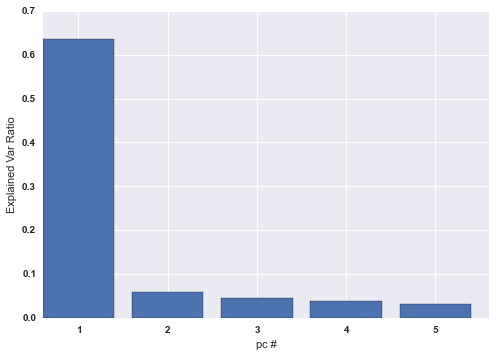

In [264]:
X = df_2011.ix[:,2:32]
X_PC = plot_exp_var_ratio(X,N)